In [22]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '../'))
sys.path.append(parent_dir)
from em_utils import * # import the utils

In [ ]:
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/merf_dfs/"
os.makedirs(df_dir, exist_ok=True)

print("---------- Read data ----------")
input_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/april_processing/"
delta = read_data(input_dir, "all_delta.csv")
print(delta.columns.to_list())

In [ ]:
#Make time numeric 
time_mapping = {
    "BL": 0,
    "6m": 6,
    "12m": 12
}
delta['time'] = delta['time'].replace(time_mapping)
print(delta['time'])

In [25]:
# Make omic subsets
BMI_VAR, ID_VAR, TIME_VAR, DATA = 'outcome_BMI_fnl', 'subject_id.x', 'time', delta
# Define the column names based on your lists
basic = [BMI_VAR, ID_VAR, TIME_VAR, 'sex', 'age']
meta_keep = [BMI_VAR, ID_VAR, TIME_VAR, 'randomized_group', 'sex', 'race', 
             'age', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = [BMI_VAR, ID_VAR, TIME_VAR, 'bmi_prs']
only_taxa = [BMI_VAR, ID_VAR, TIME_VAR,] + [col for col in DATA.columns if col.startswith("g__")]

micom_start = DATA.columns.get_loc("Diacetyl")
micom_end = DATA.columns.get_loc("aldehydo.D.xylose")
only_micom = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[micom_start:micom_end + 1])

path_start = DATA.columns.get_loc("arginine..ornithine.and.proline.interconversion")
path_end = DATA.columns.get_loc("UDP.N.acetyl.D.glucosamine.biosynthesis.I")
only_pathway = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[path_start:path_end + 1])

In [ ]:
# Make train and test sets 
# test sample names
test_names = ["ABR-079", "AGA-071", "AHE-055", "ALI-121", "ALO-163", "AMA-031", "ASO-013", "AWI-167", "BMO-164", "CWA-183", "DSC-024", "EBE-130", "EHI-177", "EJO-092", "GFU-188", "HGI-010", "JCA-109", "JGO-100",
    "KBU-085", "KCE-034", "KHE-170", "LDO-148", "LST-186", "LZD-142", "MAR-119", "MCA-088", "MJA-153", "MWE-112", "NPO-149", "RAE-114", "SBO-020", "SEG-080", "SKA-195", "SLO-178", "SSH-028", "TDU-086","TFA-016", "VCA-041"]
# train sample names
train_names = ["AAL-144", "ACO-053", "ADA-105", "AKE-009", "AKI-011", "AKO-139", "AMC-155", "AME-128", "AME-157", "ATA-129", "AWA-052", "AWA-083", "BAN-193", "BHO-014", "BIN-201", "BKN-104", "BMI-156", "BSA-174", "CAM-057", "CCO-189",
    "CED-026", "CEL-073", "CGA-134", "CIS-077", "CKR-078", "CLE-049", "COW-066", "CRO-108", "CWA-161", "EBE-051", "EKA-135", "EKR-045", "ELA-159", "EPO-182", "EVO-184", "FWI-098", "GHA-035", "HDE-154", "IBE-120", "JDI-140", "JER-110", "JFU-027", "JJO-093", "JKN-127", "JPO-022", "JUG-116", "JUT-032", "JVE-126", "KAN-138", "KBR-162", "KEL-185", "KEL-199", "KGI-029", "KHU-196", "KPA-042", "KRI-072", "KVA-038", "KWA-122", "KWA-141", "LBL-047", "LBU-015", "LEL-147", "LFI-003", "LJA-101", "LMC-111", "LPF-198", "LVA-017", "MBA-187", "MCW-065", "MDI-107", "MES-068", "MFB-118", "MGA-076", "MHO-117", "MKE-192", "MMA-036", "MRT-179", "MSH-091", "MST-039", "MWE-143",
    "MWO-133", "MWY-152", "NAR-099", "NBI-048", "NBI-069", "NCO-171", "NDI-067", "NEL-094", "NKA-090", "NMO-151", "NTA-021", "PBE-123", "QNG-166", "RAF-125", "RAM-050", "RHP-023", "RLA-132", "ROL-006", "SAB-160", "SCA-043", "SCR-061", "SDA-150", "SGA-062", "SKA-087", "SRO-194", "TBU-115", "TFA-172", "TRO-113", "TSH-146", "TSL-056", "WPE-005", "YOR-103", "YSU-097", "ZVU-096"]
print("Length of test names:", len(test_names))
print("Length of train names:", len(train_names))

INFO     [merf.py:307] Training GLL is -38.77635577048497 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -53.84314545494612 at iteration 2.
INFO     [merf.py:307] Training GLL is 3.3691820373961194 at iteration 1.


Subset for only_pathway created with shape: (196, 114)
---------- Select predictors for training set ----------
Length of X: 140, Length of clusters_train: 140, Length of Y: 140
Final columns after drop: ['time', 'arginine..ornithine.and.proline.interconversion', 'reductive.acetyl.coenzyme.A.pathway', 'mixed.acid.fermentation', 'superpathway.of.fucose.and.rhamnose.degradation', 'D.glucarate.degradation.I', 'glucose.and.glucose.1.phosphate.degradation', 'superpathway.of..beta..D.glucuronide.and.D.glucuronate.degradation', 'superpathway.of.glycerol.degradation.to.1.3.propanediol', 'heme.biosynthesis.II..anaerobic.', 'superpathway.of.hexitol.degradation..bacteria.', 'L.histidine.degradation.I', 'L.methionine.biosynthesis.III', 'ketogluconate.metabolism', 'lactose.and.galactose.degradation.I', 'L.leucine.degradation.I', 'NAD.salvage.pathway.II', 'pyruvate.fermentation.to.propanoate.I', 'Bifidobacterium.shunt', 'superpathway.of..R.R..butanediol.biosynthesis', 'L.glutamate.degradation.V..via

INFO     [merf.py:307] Training GLL is 42.04956687884829 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.506212104542445 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 77.03337683633093 at iteration 2.
INFO     [merf.py:307] Training GLL is -4.74096003498283 at iteration 1.


Combination, ptev: 0.1007, prev: 0.8993, OOB Score: 15.8000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: -0.0167, prev: 1.0167, OOB Score: -4.4000
Combination: (10, None, 0.05, 2, 5)

Progress: 3.70% completed

Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -19.203823648884242 at iteration 2.
INFO     [merf.py:307] Training GLL is -29.1369637417556 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -38.63687787455296 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: -0.2068, prev: 1.2068, OOB Score: 26.6000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: -0.1845, prev: 1.1845, OOB Score: 34.7000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 50.61136462208408 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 86.6867748957667 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: -0.0752, prev: 1.0752, OOB Score: -4.7000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: -0.1299, prev: 1.1299, OOB Score: -7.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 50.92492190647221 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 3.2064069510856323 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 35.16348331436497 at iteration 2.
INFO     [merf.py:307] Training GLL is 50.596988057161845 at iteration 1.


Combination, ptev: -0.1166, prev: 1.1166, OOB Score: 21.8000
Combination: (10, None, 0.05, 2, 10)

Progress: 5.56% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.4725, prev: 1.4725, OOB Score: 29.8000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 40.316964933563085 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 33.45136256600445 at iteration 1.
INFO     [merf.py:307] Training GLL is 65.6956031077115 at iteration 2.


Combination, ptev: -0.3431, prev: 1.3431, OOB Score: 18.5000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2101, prev: 1.2101, OOB Score: 24.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -0.6310236399670333 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 10.728979594240043 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs 

Combination, ptev: -0.2039, prev: 1.2039, OOB Score: 14.6000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2406, prev: 1.2406, OOB Score: 22.1000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 50.28008066567135 at iteration 1.
INFO     [merf.py:307] Training GLL is 68.64408704042864 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 27.774076367920987 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: -0.2496, prev: 1.2496, OOB Score: 12.4000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2259, prev: 1.2259, OOB Score: 20.8000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 90.62360241306413 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 78.57454528696668 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.2842, prev: 1.2842, OOB Score: 28.6000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2478, prev: 1.2478, OOB Score: 24.9000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 54.2205987575205 at iteration 2.
INFO     [merf.py:307] Training GLL is -18.913588024184747 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -15.079191229042824 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: -0.2277, prev: 1.2277, OOB Score: -1.7000
Combination: (10, None, 0.05, 10, 3)

Progress: 7.41% completed

Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -33.4898291682895 at iteration 4.
INFO     [merf.py:307] Training GLL is -36.119931146027525 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -39.234501023468766 at iteration 6.
INFO     [merf.py:307] Training GLL is -32.94143923950506 at iteration 7.
INFO     [merf.py:307] Training GLL is -39.05200106493184 a

Combination, ptev: 0.0156, prev: 0.9844, OOB Score: 34.3000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 50.77722328307677 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 42.269348117686484 at iteration 6.
INFO     [merf.py:307] Training GLL is 35.39211667394548 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 19.559361301193753 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

Combination, ptev: 0.0537, prev: 0.9463, OOB Score: 8.4000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 74.21726002631522 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 86.32658164428443 at iteration 5.
INFO     [merf.py:307] Training GLL is 70.20296050423343 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 63.86131867529011 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pre

Combination, ptev: -0.0840, prev: 1.0840, OOB Score: 9.5000
Combination: (10, None, 0.05, 10, 5)

Progress: 9.26% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 31.082760123328605 at iteration 4.
INFO     [merf.py:307] Training GLL is 18.092871071923042 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 7.509929795295788 at iteration 6.
INFO     [merf.py:307] Training GLL is 16.15120233785975 at iteration 7.
INFO     [merf.py:307] Training GLL is 52.575228207770394 at iteration 8.
INFO     [merf.py:307] Training GLL is 25.09000909771901 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This p

Combination, ptev: -0.2427, prev: 1.2427, OOB Score: 30.7000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -14.2463039062632 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 4.7824139834906845 at iteration 5.
INFO     [merf.py:307] Training GLL is 19.75290330558667 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: -0.1492, prev: 1.1492, OOB Score: 23.8000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 56.928961481771175 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 61.54780184370489 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.0020, prev: 0.9980, OOB Score: 31.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 100.54750455877358 at iteration 3.
INFO     [merf.py:307] Training GLL is 79.75675050919804 at iteration 4.
INFO     [merf.py:307] Training GLL is 65.52815688751906 at iteration 5.
INFO     [merf.py:307] Training GLL is 78.0946024704701 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 96.92289064800532 at iteration 7.
INFO     [merf.py:307] Training GLL is 89.13199551281275 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This prob

Combination, ptev: -0.0268, prev: 1.0268, OOB Score: 12.8000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 79.01583067718984 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 70.00547068608964 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.0326, prev: 1.0326, OOB Score: 7.1000
Combination: (10, None, 0.05, 10, 10)

Progress: 11.11% completed

Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 44.56254059025673 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 57.57061134349055 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.5852, prev: 1.5852, OOB Score: 37.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 50.52185554785684 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 70.39026315926101 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.2794, prev: 1.2794, OOB Score: 33.1000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 42.34434733119382 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 57.707111059152744 at iteration 5.
INFO     [merf.py:307] Training GLL is 38.583555834999764 at iteration 6.
INFO     [merf.py:307] Training GLL is 54.344025693904975 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-

Combination, ptev: -0.2201, prev: 1.2201, OOB Score: 26.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 44.530900442302986 at iteration 3.
INFO     [merf.py:307] Training GLL is 45.19979087015875 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 28.709176560871263 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 37.71793008050601 at iteration 6.
INFO     [merf.py:307] Training GLL is 22.44278320641968 at it

Combination, ptev: -0.1857, prev: 1.1857, OOB Score: 25.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 85.2274028102765 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 89.22838028984523 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: -0.2049, prev: 1.2049, OOB Score: 21.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 74.26820688272684 at iteration 3.
INFO     [merf.py:307] Training GLL is 82.27981890433088 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 102.45560179032192 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: -0.1570, prev: 1.1570, OOB Score: 16.1000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 82.3326631718283 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 85.42203292058356 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: -0.1753, prev: 1.1753, OOB Score: 17.1000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 111.69690031026293 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 101.7951722245538 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: -0.4206, prev: 1.4206, OOB Score: 29.2000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 59.83934938510758 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 70.70866591162948 at iteration 5.
INFO     [merf.py:307] Training GLL is 93.31407260296035 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: -0.3686, prev: 1.3686, OOB Score: 17.6000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 106.9746827438775 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 77.95110081114146 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.3344, prev: 1.3344, OOB Score: 9.8000
Combination: (10, None, 0.1, 2, 3)

Progress: 12.96% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.0296, prev: 0.9704, OOB Score: 27.8000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 74.52604279471129 at iteration 2.
INFO     [merf.py:307] Training GLL is 90.97830886609005 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 129.6603327692391 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 42.82639021727955 at iteration 1.


Combination, ptev: 0.1075, prev: 0.8925, OOB Score: 12.0000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: -0.0002, prev: 1.0002, OOB Score: -9.9000
Combination: (10, None, 0.1, 2, 5)

Progress: 14.81% completed

Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 62.50008877342073 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 55.619190539976984 at iteration 1.
INFO     [merf.py:307] Training GLL is 22.92741054820504 at iteration 2.
INFO     [merf.py:307] Training GLL is 79.13613431519704 at iteration 1.


Combination, ptev: -0.3261, prev: 1.3261, OOB Score: 33.7000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: -0.1575, prev: 1.1575, OOB Score: 42.9000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 95.55590220706046 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 101.81196617857503 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.0211, prev: 0.9789, OOB Score: 25.1000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: -0.0535, prev: 1.0535, OOB Score: 15.9000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 79.99299899310307 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 89.24389438898056 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.0483, prev: 1.0483, OOB Score: 1.4000
Combination: (10, None, 0.1, 2, 10)

Progress: 16.67% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.4723, prev: 1.4723, OOB Score: 32.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 78.47587371854611 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 70.88204353014919 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 89.7308960174969 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: -0.4419, prev: 1.4419, OOB Score: 27.1000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.3071, prev: 1.3071, OOB Score: 28.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 86.78494236876689 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 94.44029960812117 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 109.21512076399743 at iteration 2.
INFO     [merf.py:307] Training GLL is 78.68821719707682 at iteration 1.


Combination, ptev: -0.1978, prev: 1.1978, OOB Score: 25.0000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2395, prev: 1.2395, OOB Score: 20.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 118.4509391304221 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.87771330760805 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 123.0092116893841 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: -0.2240, prev: 1.2240, OOB Score: 19.9000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.1948, prev: 1.1948, OOB Score: 17.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 122.70573020767026 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 98.0800962879772 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.3315, prev: 1.3315, OOB Score: 22.9000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2682, prev: 1.2682, OOB Score: 9.8000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 111.71611472000555 at iteration 2.
INFO     [merf.py:307] Training GLL is -7.116524141478449 at iteration 1.
INFO     [merf.py:307] Training GLL is 3.6970753691111162 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 0.6795490348850404 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic

Combination, ptev: -0.2439, prev: 1.2439, OOB Score: 19.2000
Combination: (10, None, 0.1, 10, 3)

Progress: 18.52% completed

Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 4.941060597228792 at iteration 5.
INFO     [merf.py:307] Training GLL is 17.886687311992254 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 8.953052482256219 at iteration 7.
INFO     [merf.py:307] Training GLL is 9.303803094223575 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: 0.0412, prev: 0.9588, OOB Score: 38.0000
Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 71.62371655491293 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 82.3420806428196 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.79667328363274 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.1323, prev: 0.8677, OOB Score: 18.3000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 106.90158924227357 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.92032847481455 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 100.20713600476311 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: -0.0068, prev: 1.0068, OOB Score: 14.8000
Combination: (10, None, 0.1, 10, 5)

Progress: 20.37% completed

Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 54.167382321345315 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 61.643562005517204 at iteration 5.
INFO     [merf.py:307] Training GLL is 63.89993975386059 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: -0.4159, prev: 1.4159, OOB Score: 49.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 16.500255312503008 at iteration 4.
INFO     [merf.py:307] Training GLL is 28.544192006232265 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 34.450411033970475 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 33.16317422946972 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-

Combination, ptev: -0.2204, prev: 1.2204, OOB Score: 33.4000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 117.58796422698813 at iteration 4.
INFO     [merf.py:307] Training GLL is 111.00432305523705 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 123.63018128389261 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: -0.0620, prev: 1.0620, OOB Score: 17.0000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 119.14066418678168 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 119.41905341935875 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: -0.0943, prev: 1.0943, OOB Score: 30.3000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 110.63269953915623 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 118.01582439357794 at iteration 5.
INFO     [merf.py:307] Training GLL is 112.4229331824559 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: -0.1452, prev: 1.1452, OOB Score: 19.6000
Combination: (10, None, 0.1, 10, 10)

Progress: 22.22% completed

Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 97.28650580412614 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 87.45156424341445 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: -0.2168, prev: 1.2168, OOB Score: 32.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 109.96610857484548 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 95.21428999011849 at iteration 5.
INFO     [merf.py:307] Training GLL is 81.01724240860159 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 89.91457561211716 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: -0.1857, prev: 1.1857, OOB Score: 30.9000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 92.19397409461182 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 75.53851574775007 at iteration 5.
INFO     [merf.py:307] Training GLL is 79.77516393075665 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.18585997284535 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pre

Combination, ptev: -0.1544, prev: 1.1544, OOB Score: 1.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 83.4890681554405 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 64.02306138414048 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: -0.1151, prev: 1.1151, OOB Score: 25.9000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 126.16482340583097 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 126.24104555495333 at iteration 5.
INFO     [merf.py:307] Training GLL is 116.14507308328673 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: -0.1474, prev: 1.1474, OOB Score: 21.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 89.68304621226574 at iteration 4.
INFO     [merf.py:307] Training GLL is 94.19285832612579 at iteration 5.
INFO     [merf.py:307] Training GLL is 109.2603003321012 at iteration 6.
INFO     [merf.py:307] Training GLL is 110.49404438343788 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 112.79153474724403 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimate

Combination, ptev: -0.1576, prev: 1.1576, OOB Score: 22.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 116.72206850021213 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 119.53398410065125 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: -0.1522, prev: 1.1522, OOB Score: 17.4000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 117.54929940297593 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 122.5699923164931 at iteration 5.
INFO     [merf.py:307] Training GLL is 118.12087182996171 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: -0.3176, prev: 1.3176, OOB Score: 24.7000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.47651914306196 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 127.54627585524192 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: -0.2827, prev: 1.2827, OOB Score: 28.8000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 123.73546388667212 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 138.32806171836566 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: -0.2579, prev: 1.2579, OOB Score: 10.7000
Combination: (10, None, 0.15, 2, 3)

Progress: 24.07% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: -0.0080, prev: 1.0080, OOB Score: 21.7000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 95.16424942208266 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 123.04954939239407 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 149.45238825858738 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.0756, prev: 0.9244, OOB Score: 15.8000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: -0.0510, prev: 1.0510, OOB Score: -1.7000
Combination: (10, None, 0.15, 2, 5)

Progress: 25.93% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 68.8950606241437 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 64.91042386872196 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 51.5424944129941 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site

Combination, ptev: -0.1990, prev: 1.1990, OOB Score: 38.1000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: -0.1187, prev: 1.1187, OOB Score: 38.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 122.86837151851503 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 103.41461879555452 at iteration 1.
INFO     [merf.py:307] Training GLL is 146.14920564791564 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 116.22510026873358 at iteration 1.


Combination, ptev: 0.0372, prev: 0.9628, OOB Score: 15.4000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: -0.0622, prev: 1.0622, OOB Score: 19.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 107.56291504123796 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 119.74137110977318 at iteration 1.
INFO     [merf.py:307] Training GLL is 111.43716795223166 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.16224202855486 at iteration 1.


Combination, ptev: -0.0954, prev: 1.0954, OOB Score: 35.8000
Combination: (10, None, 0.15, 2, 10)

Progress: 27.78% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.7560, prev: 1.7560, OOB Score: 37.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 108.23515866020412 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 107.01256186530006 at iteration 1.
INFO     [merf.py:307] Training GLL is 106.48126047260624 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: -0.4501, prev: 1.4501, OOB Score: 18.0000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.3186, prev: 1.3186, OOB Score: 33.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 134.97125028677854 at iteration 2.
INFO     [merf.py:307] Training GLL is 136.3746785759026 at iteration 1.
INFO     [merf.py:307] Training GLL is 139.73023743489608 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 134.88781883557814 at iteration 1.


Combination, ptev: -0.2373, prev: 1.2373, OOB Score: 33.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2174, prev: 1.2174, OOB Score: 25.1000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 144.6551513793447 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 106.52345093990608 at iteration 1.
INFO     [merf.py:307] Training GLL is 124.69995479128279 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: -0.1906, prev: 1.1906, OOB Score: 24.1000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.1799, prev: 1.1799, OOB Score: 27.9000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 161.28293444800264 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 118.77978259568418 at iteration 1.
INFO     [merf.py:307] Training GLL is 140.9926087103606 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: -0.2845, prev: 1.2845, OOB Score: 13.9000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.2340, prev: 1.2340, OOB Score: 27.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 136.24479661755 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -4.032745554364331 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: -0.2144, prev: 1.2144, OOB Score: 33.0000
Combination: (10, None, 0.15, 10, 3)

Progress: 29.63% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 27.471651620236653 at iteration 4.
INFO     [merf.py:307] Training GLL is 26.69958821870463 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 23.620225629098854 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 24.431815911196228 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-

Combination, ptev: -0.0230, prev: 1.0230, OOB Score: 42.3000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 105.0577222225652 at iteration 5.
INFO     [merf.py:307] Training GLL is 88.11700758793731 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 101.23279606336887 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 93.96672371003913 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: 0.1202, prev: 0.8798, OOB Score: 17.6000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 152.28327102949447 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 167.26645293411838 at iteration 5.
INFO     [merf.py:307] Training GLL is 149.32179628959676 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 141.65326882928164 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic

Combination, ptev: 0.0356, prev: 0.9644, OOB Score: 4.3000
Combination: (10, None, 0.15, 10, 5)

Progress: 31.48% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 89.70357818312596 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 85.78287850188447 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 70.53872165689118 at iteration 7.
INFO     [merf.py:307] Training GLL is 72.8789028532942 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pred

Combination, ptev: -0.3212, prev: 1.3212, OOB Score: 24.3000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 78.85666523628214 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 69.33778590425906 at iteration 6.
INFO     [merf.py:307] Training GLL is 74.36452324612787 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: -0.1099, prev: 1.1099, OOB Score: 25.9000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 137.37080794482486 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 134.71947125970848 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.0132, prev: 0.9868, OOB Score: 24.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 139.74407692462103 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 144.774541779802 at iteration 5.
INFO     [merf.py:307] Training GLL is 144.20245960982524 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 148.2140742381602 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: -0.0932, prev: 1.0932, OOB Score: 20.5000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 139.6981056986648 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 142.88630914969502 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: -0.1079, prev: 1.1079, OOB Score: 26.7000
Combination: (10, None, 0.15, 10, 10)

Progress: 33.33% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 123.48892371543994 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 125.9952281587095 at iteration 6.
INFO     [merf.py:307] Training GLL is 128.08415021321372 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 111.51227597086151 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-

Combination, ptev: -0.4247, prev: 1.4247, OOB Score: 41.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 103.67391829342702 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 101.71759827219198 at iteration 5.
INFO     [merf.py:307] Training GLL is 100.8210484630962 at iteration 6.
INFO     [merf.py:307] Training GLL is 127.33827056995267 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 120.6544108315478 at i

Combination, ptev: -0.3546, prev: 1.3546, OOB Score: 17.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 126.92164794567441 at iteration 5.
INFO     [merf.py:307] Training GLL is 85.9579446619954 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 107.90083756413226 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 105.89651411377884 at iteration 8.
INFO     [merf.py:307] Training GLL is 103.13815551324603 at i

Combination, ptev: -0.2918, prev: 1.2918, OOB Score: 23.2000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 95.64236398698455 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 112.15894353979873 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: -0.2386, prev: 1.2386, OOB Score: 23.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 147.04623085931766 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 146.39740776299158 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 158.60408938520405 at iteration 6.
INFO     [merf.py:307] Training GLL is 136.65471316270782 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic

Combination, ptev: -0.1659, prev: 1.1659, OOB Score: 17.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 134.67543460878156 at iteration 4.
INFO     [merf.py:307] Training GLL is 135.28856463848453 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 148.5602618369328 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: -0.1764, prev: 1.1764, OOB Score: 18.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 151.27731191920373 at iteration 4.
INFO     [merf.py:307] Training GLL is 153.82335439672258 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 156.02412926653403 at iteration 6.
INFO     [merf.py:307] Training GLL is 140.15849390976908 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 140.78891142892974 at

Combination, ptev: -0.1968, prev: 1.1968, OOB Score: 16.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 162.05848641780756 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 155.67770840822553 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: -0.4571, prev: 1.4571, OOB Score: 27.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 143.88315466236642 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 150.24031297124432 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: -0.3933, prev: 1.3933, OOB Score: 17.2000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 146.2423253918502 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 157.66292677575234 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: -0.3589, prev: 1.3589, OOB Score: 22.9000
Combination: (50, None, 0.05, 2, 3)

Progress: 35.19% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -40.003069776336766 at iteration 2.
INFO     [merf.py:307] Training GLL is 17.113309369331194 at iteration 1.


Combination, ptev: 0.0165, prev: 0.9835, OOB Score: 36.9000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 32.144772320958744 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.94324874812136 at iteration 1.


Combination, ptev: 0.0918, prev: 0.9082, OOB Score: 25.8000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 47.43975250635951 at iteration 2.
INFO     [merf.py:307] Training GLL is -4.447273510357426 at iteration 1.


Combination, ptev: 0.0112, prev: 0.9888, OOB Score: 13.1000
Combination: (50, None, 0.05, 2, 5)

Progress: 37.04% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -7.201781418437729 at iteration 2.
INFO     [merf.py:307] Training GLL is -19.460629443583517 at iteration 1.


Combination, ptev: -0.3490, prev: 1.3490, OOB Score: 42.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -27.465850753570724 at iteration 2.
INFO     [merf.py:307] Training GLL is 32.459611266631484 at iteration 1.


Combination, ptev: -0.1629, prev: 1.1629, OOB Score: 38.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 39.8827836644152 at iteration 2.
INFO     [merf.py:307] Training GLL is 15.120054859816316 at iteration 1.


Combination, ptev: -0.0218, prev: 1.0218, OOB Score: 25.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 34.304138677528826 at iteration 2.
INFO     [merf.py:307] Training GLL is 32.23689264739034 at iteration 1.


Combination, ptev: -0.0377, prev: 1.0377, OOB Score: 26.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 51.44420763178856 at iteration 2.
INFO     [merf.py:307] Training GLL is -1.4275500291552157 at iteration 1.


Combination, ptev: -0.0062, prev: 1.0062, OOB Score: 17.6000
Combination: (50, None, 0.05, 2, 10)

Progress: 38.89% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 26.961991195107487 at iteration 2.
INFO     [merf.py:307] Training GLL is 21.636468195408742 at iteration 1.


Combination, ptev: -0.5199, prev: 1.5199, OOB Score: 36.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 25.641092694501808 at iteration 2.
INFO     [merf.py:307] Training GLL is 4.129092406066894 at iteration 1.


Combination, ptev: -0.4469, prev: 1.4469, OOB Score: 32.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 23.37776770710928 at iteration 2.
INFO     [merf.py:307] Training GLL is 14.135992170887079 at iteration 1.


Combination, ptev: -0.2710, prev: 1.2710, OOB Score: 35.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 13.818360437801365 at iteration 2.
INFO     [merf.py:307] Training GLL is 39.33869238380266 at iteration 1.


Combination, ptev: -0.1872, prev: 1.1872, OOB Score: 34.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 48.32802457784892 at iteration 2.
INFO     [merf.py:307] Training GLL is 24.313062193762793 at iteration 1.


Combination, ptev: -0.1804, prev: 1.1804, OOB Score: 27.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 49.79903066505085 at iteration 2.
INFO     [merf.py:307] Training GLL is 23.846161909739624 at iteration 1.


Combination, ptev: -0.1338, prev: 1.1338, OOB Score: 31.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 44.66373951007501 at iteration 2.
INFO     [merf.py:307] Training GLL is 29.73560812802484 at iteration 1.


Combination, ptev: -0.1310, prev: 1.1310, OOB Score: 26.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 59.25745962000956 at iteration 2.
INFO     [merf.py:307] Training GLL is 41.10464274313666 at iteration 1.


Combination, ptev: -0.2222, prev: 1.2222, OOB Score: 29.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 67.49400910598818 at iteration 2.
INFO     [merf.py:307] Training GLL is 39.11485357184724 at iteration 1.


Combination, ptev: -0.1868, prev: 1.1868, OOB Score: 27.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 66.58192075039702 at iteration 2.
INFO     [merf.py:307] Training GLL is -41.15082803469924 at iteration 1.


Combination, ptev: -0.1672, prev: 1.1672, OOB Score: 24.3000
Combination: (50, None, 0.05, 10, 3)

Progress: 40.74% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -42.41427430567652 at iteration 2.
INFO     [merf.py:307] Training GLL is -52.84866544428119 at iteration 3.
INFO     [merf.py:307] Training GLL is -47.25433051295812 at iteration 4.
INFO     [merf.py:307] Training GLL is -65.33507667651624 at iteration 5.
INFO     [merf.py:307] Training GLL is -58.05514291887562 at iteration 6.
INFO     [merf.py:307] Training GLL is -55.625001895754636 at iteration 7.
INFO     [merf.py:307] Training GLL is -52.05538008642527 at iteration 8.
INFO     [merf.py:307] Training GLL is -60.44193438833505 at iteration 9.
INFO     [merf.py:307] Training GLL is -46.60282783324013 at iteration 10.
INFO     [merf.py:307] Training GLL is 8.584257965886405 at iteration 1.


Combination, ptev: 0.0710, prev: 0.9290, OOB Score: 39.2000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 31.003907115509733 at iteration 2.
INFO     [merf.py:307] Training GLL is 28.636732356457635 at iteration 3.
INFO     [merf.py:307] Training GLL is 32.095041352485104 at iteration 4.
INFO     [merf.py:307] Training GLL is 32.620997506402595 at iteration 5.
INFO     [merf.py:307] Training GLL is 36.73901284478101 at iteration 6.
INFO     [merf.py:307] Training GLL is 34.93894015299789 at iteration 7.
INFO     [merf.py:307] Training GLL is 30.07648849684963 at iteration 8.
INFO     [merf.py:307] Training GLL is 34.280450609971226 at iteration 9.
INFO     [merf.py:307] Training GLL is 33.92298810156718 at iteration 10.
INFO     [merf.py:307] Training GLL is 21.259919847514357 at iteration 1.


Combination, ptev: 0.1515, prev: 0.8485, OOB Score: 29.8000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 36.6863871211775 at iteration 2.
INFO     [merf.py:307] Training GLL is 55.84794231186219 at iteration 3.
INFO     [merf.py:307] Training GLL is 62.578970222230716 at iteration 4.
INFO     [merf.py:307] Training GLL is 64.35259254784545 at iteration 5.
INFO     [merf.py:307] Training GLL is 69.12660838515754 at iteration 6.
INFO     [merf.py:307] Training GLL is 71.93804955028592 at iteration 7.
INFO     [merf.py:307] Training GLL is 65.55911979144389 at iteration 8.
INFO     [merf.py:307] Training GLL is 70.19827659886461 at iteration 9.
INFO     [merf.py:307] Training GLL is 72.25741275992178 at iteration 10.
INFO     [merf.py:307] Training GLL is -18.41803082700104 at iteration 1.


Combination, ptev: -0.0087, prev: 1.0087, OOB Score: 34.2000
Combination: (50, None, 0.05, 10, 5)

Progress: 42.59% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -16.599638072722207 at iteration 2.
INFO     [merf.py:307] Training GLL is -3.4717544385992682 at iteration 3.
INFO     [merf.py:307] Training GLL is 2.4829468903899654 at iteration 4.
INFO     [merf.py:307] Training GLL is 1.9999842384284674 at iteration 5.
INFO     [merf.py:307] Training GLL is 6.978818980328652 at iteration 6.
INFO     [merf.py:307] Training GLL is -0.9693766801675495 at iteration 7.
INFO     [merf.py:307] Training GLL is 8.356025372984767 at iteration 8.
INFO     [merf.py:307] Training GLL is 12.225175377663819 at iteration 9.
INFO     [merf.py:307] Training GLL is -1.7243734912382958 at iteration 10.
INFO     [merf.py:307] Training GLL is -24.991895140681166 at iteration 1.


Combination, ptev: -0.3396, prev: 1.3396, OOB Score: 48.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -19.71357845691085 at iteration 2.
INFO     [merf.py:307] Training GLL is -16.155503691070795 at iteration 3.
INFO     [merf.py:307] Training GLL is -36.220688017785626 at iteration 4.
INFO     [merf.py:307] Training GLL is -26.73239083152499 at iteration 5.
INFO     [merf.py:307] Training GLL is -36.92351465992464 at iteration 6.
INFO     [merf.py:307] Training GLL is -46.675360117660944 at iteration 7.
INFO     [merf.py:307] Training GLL is -41.83554844086818 at iteration 8.
INFO     [merf.py:307] Training GLL is -38.06398294403114 at iteration 9.
INFO     [merf.py:307] Training GLL is -36.10000101196614 at iteration 10.
INFO     [merf.py:307] Training GLL is 27.691649715955297 at iteration 1.


Combination, ptev: -0.1558, prev: 1.1558, OOB Score: 45.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 50.554823542983065 at iteration 2.
INFO     [merf.py:307] Training GLL is 48.932884640118 at iteration 3.
INFO     [merf.py:307] Training GLL is 53.31570127795292 at iteration 4.
INFO     [merf.py:307] Training GLL is 62.38440865382164 at iteration 5.
INFO     [merf.py:307] Training GLL is 64.17325561964027 at iteration 6.
INFO     [merf.py:307] Training GLL is 67.78032362777455 at iteration 7.
INFO     [merf.py:307] Training GLL is 65.39711485004955 at iteration 8.
INFO     [merf.py:307] Training GLL is 65.52639639592539 at iteration 9.
INFO     [merf.py:307] Training GLL is 66.59033201833356 at iteration 10.
INFO     [merf.py:307] Training GLL is 36.60762047637127 at iteration 1.


Combination, ptev: 0.0059, prev: 0.9941, OOB Score: 40.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 54.59664811513762 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.9031679361669 at iteration 3.
INFO     [merf.py:307] Training GLL is 70.65071554255375 at iteration 4.
INFO     [merf.py:307] Training GLL is 64.03776885676926 at iteration 5.
INFO     [merf.py:307] Training GLL is 66.9262345219427 at iteration 6.
INFO     [merf.py:307] Training GLL is 70.97243321671736 at iteration 7.
INFO     [merf.py:307] Training GLL is 74.56949223830635 at iteration 8.
INFO     [merf.py:307] Training GLL is 71.26534291779046 at iteration 9.
INFO     [merf.py:307] Training GLL is 76.98490215771584 at iteration 10.
INFO     [merf.py:307] Training GLL is 38.16130356191189 at iteration 1.


Combination, ptev: -0.0808, prev: 1.0808, OOB Score: 42.4000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 52.66763002855025 at iteration 2.
INFO     [merf.py:307] Training GLL is 53.05232289199963 at iteration 3.
INFO     [merf.py:307] Training GLL is 61.35766762050046 at iteration 4.
INFO     [merf.py:307] Training GLL is 52.77609505161224 at iteration 5.
INFO     [merf.py:307] Training GLL is 68.96471761290452 at iteration 6.
INFO     [merf.py:307] Training GLL is 72.25979541342319 at iteration 7.
INFO     [merf.py:307] Training GLL is 71.67620793199853 at iteration 8.
INFO     [merf.py:307] Training GLL is 69.72875738773452 at iteration 9.
INFO     [merf.py:307] Training GLL is 69.90937347686821 at iteration 10.
INFO     [merf.py:307] Training GLL is 0.05291842392579171 at iteration 1.


Combination, ptev: -0.0789, prev: 1.0789, OOB Score: 24.4000
Combination: (50, None, 0.05, 10, 10)

Progress: 44.44% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 18.659511218915448 at iteration 2.
INFO     [merf.py:307] Training GLL is 27.7881257494984 at iteration 3.
INFO     [merf.py:307] Training GLL is 36.05978986768179 at iteration 4.
INFO     [merf.py:307] Training GLL is 27.881123877067665 at iteration 5.
INFO     [merf.py:307] Training GLL is 31.98762427942424 at iteration 6.
INFO     [merf.py:307] Training GLL is 35.95629985278047 at iteration 7.
INFO     [merf.py:307] Training GLL is 44.939048869205095 at iteration 8.
INFO     [merf.py:307] Training GLL is 46.77595152211223 at iteration 9.
INFO     [merf.py:307] Training GLL is 48.277907624290535 at iteration 10.
INFO     [merf.py:307] Training GLL is -8.457445089075634 at iteration 1.


Combination, ptev: -0.4853, prev: 1.4853, OOB Score: 46.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 2.2390622258733224 at iteration 2.
INFO     [merf.py:307] Training GLL is 26.02351097919483 at iteration 3.
INFO     [merf.py:307] Training GLL is 26.053103497438777 at iteration 4.
INFO     [merf.py:307] Training GLL is 24.587965574839526 at iteration 5.
INFO     [merf.py:307] Training GLL is 19.683761921552698 at iteration 6.
INFO     [merf.py:307] Training GLL is 25.948585192474617 at iteration 7.
INFO     [merf.py:307] Training GLL is 32.014371003379146 at iteration 8.
INFO     [merf.py:307] Training GLL is 36.491516236579116 at iteration 9.
INFO     [merf.py:307] Training GLL is 13.942354462187728 at iteration 10.
INFO     [merf.py:307] Training GLL is 10.257293895954186 at iteration 1.


Combination, ptev: -0.3968, prev: 1.3968, OOB Score: 45.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 19.063853949517764 at iteration 2.
INFO     [merf.py:307] Training GLL is 16.959458756886573 at iteration 3.
INFO     [merf.py:307] Training GLL is 17.231091191059857 at iteration 4.
INFO     [merf.py:307] Training GLL is 22.303391395673067 at iteration 5.
INFO     [merf.py:307] Training GLL is 18.780679015196178 at iteration 6.
INFO     [merf.py:307] Training GLL is 25.64730428314526 at iteration 7.
INFO     [merf.py:307] Training GLL is 29.15016671508585 at iteration 8.
INFO     [merf.py:307] Training GLL is 22.058079322840396 at iteration 9.
INFO     [merf.py:307] Training GLL is 17.726616630538384 at iteration 10.
INFO     [merf.py:307] Training GLL is -7.07215797820668 at iteration 1.


Combination, ptev: -0.2591, prev: 1.2591, OOB Score: 40.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 16.269738777662244 at iteration 2.
INFO     [merf.py:307] Training GLL is 15.702053596694668 at iteration 3.
INFO     [merf.py:307] Training GLL is 17.012204649708426 at iteration 4.
INFO     [merf.py:307] Training GLL is 13.469016466741383 at iteration 5.
INFO     [merf.py:307] Training GLL is 14.877688765871657 at iteration 6.
INFO     [merf.py:307] Training GLL is 15.477144033227663 at iteration 7.
INFO     [merf.py:307] Training GLL is 16.798509793337796 at iteration 8.
INFO     [merf.py:307] Training GLL is 14.114300052140694 at iteration 9.
INFO     [merf.py:307] Training GLL is 18.50443225515444 at iteration 10.
INFO     [merf.py:307] Training GLL is 43.11497652853096 at iteration 1.


Combination, ptev: -0.1941, prev: 1.1941, OOB Score: 40.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 39.322266384722525 at iteration 2.
INFO     [merf.py:307] Training GLL is 43.07695115328822 at iteration 3.
INFO     [merf.py:307] Training GLL is 47.58777726614911 at iteration 4.
INFO     [merf.py:307] Training GLL is 42.631056366367915 at iteration 5.
INFO     [merf.py:307] Training GLL is 40.43631765653587 at iteration 6.
INFO     [merf.py:307] Training GLL is 51.76437630928918 at iteration 7.
INFO     [merf.py:307] Training GLL is 56.87844067505828 at iteration 8.
INFO     [merf.py:307] Training GLL is 58.065778834732555 at iteration 9.
INFO     [merf.py:307] Training GLL is 58.25604180763859 at iteration 10.
INFO     [merf.py:307] Training GLL is 30.60731105046946 at iteration 1.


Combination, ptev: -0.1741, prev: 1.1741, OOB Score: 33.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 54.28935324618189 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.23796466769013 at iteration 3.
INFO     [merf.py:307] Training GLL is 63.94977199522061 at iteration 4.
INFO     [merf.py:307] Training GLL is 65.66848003830643 at iteration 5.
INFO     [merf.py:307] Training GLL is 71.1684858438657 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.36819188190846 at iteration 7.
INFO     [merf.py:307] Training GLL is 80.30855430573577 at iteration 8.
INFO     [merf.py:307] Training GLL is 76.43793320105941 at iteration 9.
INFO     [merf.py:307] Training GLL is 79.27141774904473 at iteration 10.
INFO     [merf.py:307] Training GLL is 30.263340515430713 at iteration 1.


Combination, ptev: -0.1708, prev: 1.1708, OOB Score: 42.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 40.83594373925755 at iteration 2.
INFO     [merf.py:307] Training GLL is 44.89465204899817 at iteration 3.
INFO     [merf.py:307] Training GLL is 46.64833209474869 at iteration 4.
INFO     [merf.py:307] Training GLL is 52.55922046379475 at iteration 5.
INFO     [merf.py:307] Training GLL is 50.1719851843066 at iteration 6.
INFO     [merf.py:307] Training GLL is 61.25487221500513 at iteration 7.
INFO     [merf.py:307] Training GLL is 56.521461422024196 at iteration 8.
INFO     [merf.py:307] Training GLL is 64.97678283061265 at iteration 9.
INFO     [merf.py:307] Training GLL is 65.38038868921608 at iteration 10.
INFO     [merf.py:307] Training GLL is 44.283721261249596 at iteration 1.


Combination, ptev: -0.1557, prev: 1.1557, OOB Score: 38.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 55.02037915094855 at iteration 2.
INFO     [merf.py:307] Training GLL is 49.73771884668506 at iteration 3.
INFO     [merf.py:307] Training GLL is 61.403554423798965 at iteration 4.
INFO     [merf.py:307] Training GLL is 67.28938576027761 at iteration 5.
INFO     [merf.py:307] Training GLL is 61.59527506987876 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.15937114084717 at iteration 7.
INFO     [merf.py:307] Training GLL is 77.82396918637644 at iteration 8.
INFO     [merf.py:307] Training GLL is 77.57183574750549 at iteration 9.
INFO     [merf.py:307] Training GLL is 70.48623916052406 at iteration 10.
INFO     [merf.py:307] Training GLL is 25.32938295003426 at iteration 1.


Combination, ptev: -0.3542, prev: 1.3542, OOB Score: 45.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 29.783653816232835 at iteration 2.
INFO     [merf.py:307] Training GLL is 46.53851615298405 at iteration 3.
INFO     [merf.py:307] Training GLL is 63.15971525577432 at iteration 4.
INFO     [merf.py:307] Training GLL is 55.9621494257175 at iteration 5.
INFO     [merf.py:307] Training GLL is 75.8556605544295 at iteration 6.
INFO     [merf.py:307] Training GLL is 74.1552999447006 at iteration 7.
INFO     [merf.py:307] Training GLL is 64.56042011260402 at iteration 8.
INFO     [merf.py:307] Training GLL is 54.68448245341595 at iteration 9.
INFO     [merf.py:307] Training GLL is 63.920737819409474 at iteration 10.
INFO     [merf.py:307] Training GLL is 38.795005035608334 at iteration 1.


Combination, ptev: -0.3173, prev: 1.3173, OOB Score: 29.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 51.663794154609874 at iteration 2.
INFO     [merf.py:307] Training GLL is 64.8877142933589 at iteration 3.
INFO     [merf.py:307] Training GLL is 59.77954693003104 at iteration 4.
INFO     [merf.py:307] Training GLL is 63.42831059519539 at iteration 5.
INFO     [merf.py:307] Training GLL is 60.21874630666826 at iteration 6.
INFO     [merf.py:307] Training GLL is 63.5164127218482 at iteration 7.
INFO     [merf.py:307] Training GLL is 57.10610990891941 at iteration 8.
INFO     [merf.py:307] Training GLL is 58.724148254515214 at iteration 9.
INFO     [merf.py:307] Training GLL is 67.12722662255904 at iteration 10.
INFO     [merf.py:307] Training GLL is -10.078680016597486 at iteration 1.


Combination, ptev: -0.2736, prev: 1.2736, OOB Score: 34.6000
Combination: (50, None, 0.1, 2, 3)

Progress: 46.30% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 0.20028386823708733 at iteration 2.
INFO     [merf.py:307] Training GLL is 41.1531712530803 at iteration 1.


Combination, ptev: 0.0159, prev: 0.9841, OOB Score: 38.0000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 67.86901144916024 at iteration 2.
INFO     [merf.py:307] Training GLL is 53.228963705601856 at iteration 1.


Combination, ptev: 0.1232, prev: 0.8768, OOB Score: 27.4000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 90.31030421353597 at iteration 2.
INFO     [merf.py:307] Training GLL is 24.09381297784083 at iteration 1.


Combination, ptev: 0.0281, prev: 0.9719, OOB Score: 15.0000
Combination: (50, None, 0.1, 2, 5)

Progress: 48.15% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 41.733181189604345 at iteration 2.
INFO     [merf.py:307] Training GLL is 17.791541594708974 at iteration 1.


Combination, ptev: -0.2632, prev: 1.2632, OOB Score: 43.4000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 37.02334060281864 at iteration 2.
INFO     [merf.py:307] Training GLL is 66.30370413262143 at iteration 1.


Combination, ptev: -0.0973, prev: 1.0973, OOB Score: 40.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 91.23329945784764 at iteration 2.
INFO     [merf.py:307] Training GLL is 74.05275687064976 at iteration 1.


Combination, ptev: 0.0486, prev: 0.9514, OOB Score: 31.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 88.26538912228119 at iteration 2.
INFO     [merf.py:307] Training GLL is 71.19823785858071 at iteration 1.


Combination, ptev: -0.0167, prev: 1.0167, OOB Score: 34.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 98.58892430696154 at iteration 2.
INFO     [merf.py:307] Training GLL is 54.91445828186152 at iteration 1.


Combination, ptev: -0.0070, prev: 1.0070, OOB Score: 27.0000
Combination: (50, None, 0.1, 2, 10)

Progress: 50.00% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 82.07361928866699 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.82860229689879 at iteration 1.


Combination, ptev: -0.5086, prev: 1.5086, OOB Score: 41.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 75.99690148257719 at iteration 2.
INFO     [merf.py:307] Training GLL is 58.575770866853134 at iteration 1.


Combination, ptev: -0.3888, prev: 1.3888, OOB Score: 33.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 74.04307869394843 at iteration 2.
INFO     [merf.py:307] Training GLL is 54.38024805207023 at iteration 1.


Combination, ptev: -0.2694, prev: 1.2694, OOB Score: 43.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 60.43925930471577 at iteration 2.
INFO     [merf.py:307] Training GLL is 83.03887517270549 at iteration 1.


Combination, ptev: -0.1834, prev: 1.1834, OOB Score: 37.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 90.85723421541549 at iteration 2.
INFO     [merf.py:307] Training GLL is 68.54569450649977 at iteration 1.


Combination, ptev: -0.1615, prev: 1.1615, OOB Score: 31.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 99.74690856076604 at iteration 2.
INFO     [merf.py:307] Training GLL is 85.98329517041631 at iteration 1.


Combination, ptev: -0.1250, prev: 1.1250, OOB Score: 35.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 104.60338584170543 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.04283152911033 at iteration 1.


Combination, ptev: -0.1154, prev: 1.1154, OOB Score: 35.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 103.44737814083726 at iteration 2.
INFO     [merf.py:307] Training GLL is 70.70006674654239 at iteration 1.


Combination, ptev: -0.2099, prev: 1.2099, OOB Score: 33.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 97.01861117040103 at iteration 2.
INFO     [merf.py:307] Training GLL is 73.13137328691742 at iteration 1.


Combination, ptev: -0.1769, prev: 1.1769, OOB Score: 32.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 102.70059563387434 at iteration 2.
INFO     [merf.py:307] Training GLL is -11.57063959032589 at iteration 1.


Combination, ptev: -0.1556, prev: 1.1556, OOB Score: 25.3000
Combination: (50, None, 0.1, 10, 3)

Progress: 51.85% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 0.599763767511523 at iteration 2.
INFO     [merf.py:307] Training GLL is 2.6600212543666233 at iteration 3.
INFO     [merf.py:307] Training GLL is -5.832728375865477 at iteration 4.
INFO     [merf.py:307] Training GLL is -4.184557516884407 at iteration 5.
INFO     [merf.py:307] Training GLL is 0.48539572122929453 at iteration 6.
INFO     [merf.py:307] Training GLL is -4.624560099351929 at iteration 7.
INFO     [merf.py:307] Training GLL is -3.2879511949232723 at iteration 8.
INFO     [merf.py:307] Training GLL is -11.090927375984297 at iteration 9.
INFO     [merf.py:307] Training GLL is -15.347238927650194 at iteration 10.
INFO     [merf.py:307] Training GLL is 33.73089412867578 at iteration 1.


Combination, ptev: -0.0436, prev: 1.0436, OOB Score: 46.7000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 63.329036928607415 at iteration 2.
INFO     [merf.py:307] Training GLL is 70.46726864546326 at iteration 3.
INFO     [merf.py:307] Training GLL is 67.22292017663223 at iteration 4.
INFO     [merf.py:307] Training GLL is 60.79523498578852 at iteration 5.
INFO     [merf.py:307] Training GLL is 78.11676435092254 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.01267868628518 at iteration 7.
INFO     [merf.py:307] Training GLL is 66.90741977041874 at iteration 8.
INFO     [merf.py:307] Training GLL is 61.747557623496824 at iteration 9.
INFO     [merf.py:307] Training GLL is 64.64773976992056 at iteration 10.
INFO     [merf.py:307] Training GLL is 46.173340513152496 at iteration 1.


Combination, ptev: 0.1156, prev: 0.8844, OOB Score: 33.0000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 80.55810143705763 at iteration 2.
INFO     [merf.py:307] Training GLL is 90.30462818374409 at iteration 3.
INFO     [merf.py:307] Training GLL is 94.21792695247989 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.4294025741482 at iteration 5.
INFO     [merf.py:307] Training GLL is 96.70243465167415 at iteration 6.
INFO     [merf.py:307] Training GLL is 100.89394690015834 at iteration 7.
INFO     [merf.py:307] Training GLL is 99.83432627015893 at iteration 8.
INFO     [merf.py:307] Training GLL is 97.32215208767614 at iteration 9.
INFO     [merf.py:307] Training GLL is 101.16053111840077 at iteration 10.
INFO     [merf.py:307] Training GLL is 32.60543506504225 at iteration 1.


Combination, ptev: -0.0275, prev: 1.0275, OOB Score: 30.6000
Combination: (50, None, 0.1, 10, 5)

Progress: 53.70% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 47.500191293140375 at iteration 2.
INFO     [merf.py:307] Training GLL is 39.46432176974849 at iteration 3.
INFO     [merf.py:307] Training GLL is 44.79869275252814 at iteration 4.
INFO     [merf.py:307] Training GLL is 45.39100757229145 at iteration 5.
INFO     [merf.py:307] Training GLL is 41.845764046599605 at iteration 6.
INFO     [merf.py:307] Training GLL is 48.933643253245286 at iteration 7.
INFO     [merf.py:307] Training GLL is 45.787313740447274 at iteration 8.
INFO     [merf.py:307] Training GLL is 40.91992063981707 at iteration 9.
INFO     [merf.py:307] Training GLL is 45.60207611912662 at iteration 10.
INFO     [merf.py:307] Training GLL is 10.612118273523345 at iteration 1.


Combination, ptev: -0.2319, prev: 1.2319, OOB Score: 51.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 18.78558985021274 at iteration 2.
INFO     [merf.py:307] Training GLL is 20.24679171769754 at iteration 3.
INFO     [merf.py:307] Training GLL is 16.205545959543706 at iteration 4.
INFO     [merf.py:307] Training GLL is 16.052512461478376 at iteration 5.
INFO     [merf.py:307] Training GLL is 14.619313361758612 at iteration 6.
INFO     [merf.py:307] Training GLL is 8.981662738852439 at iteration 7.
INFO     [merf.py:307] Training GLL is 10.992158551464025 at iteration 8.
INFO     [merf.py:307] Training GLL is 3.6416944720020292 at iteration 9.
INFO     [merf.py:307] Training GLL is -2.1417506274585527 at iteration 10.
INFO     [merf.py:307] Training GLL is 67.99591743609243 at iteration 1.


Combination, ptev: -0.1020, prev: 1.1020, OOB Score: 37.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 89.64987060379754 at iteration 2.
INFO     [merf.py:307] Training GLL is 93.06612230390684 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.67442984959271 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.23132353105768 at iteration 5.
INFO     [merf.py:307] Training GLL is 100.0135289715428 at iteration 6.
INFO     [merf.py:307] Training GLL is 96.07906325807497 at iteration 7.
INFO     [merf.py:307] Training GLL is 94.97274342265872 at iteration 8.
INFO     [merf.py:307] Training GLL is 96.30490004922706 at iteration 9.
INFO     [merf.py:307] Training GLL is 100.94860382682204 at iteration 10.
INFO     [merf.py:307] Training GLL is 73.87829049563038 at iteration 1.


Combination, ptev: 0.0456, prev: 0.9544, OOB Score: 37.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 95.03890858012745 at iteration 2.
INFO     [merf.py:307] Training GLL is 101.12864098946375 at iteration 3.
INFO     [merf.py:307] Training GLL is 111.71078148135066 at iteration 4.
INFO     [merf.py:307] Training GLL is 112.45195237040801 at iteration 5.
INFO     [merf.py:307] Training GLL is 108.81779813937972 at iteration 6.
INFO     [merf.py:307] Training GLL is 109.74863332254776 at iteration 7.
INFO     [merf.py:307] Training GLL is 119.36608401981354 at iteration 8.
INFO     [merf.py:307] Training GLL is 111.79541481558569 at iteration 9.
INFO     [merf.py:307] Training GLL is 121.65938237611095 at iteration 10.
INFO     [merf.py:307] Training GLL is 74.45789800969457 at iteration 1.


Combination, ptev: -0.0636, prev: 1.0636, OOB Score: 41.0000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 100.97253864008675 at iteration 2.
INFO     [merf.py:307] Training GLL is 101.89166700701746 at iteration 3.
INFO     [merf.py:307] Training GLL is 97.95204600461172 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.86967187295555 at iteration 5.
INFO     [merf.py:307] Training GLL is 100.41298124882124 at iteration 6.
INFO     [merf.py:307] Training GLL is 103.7298302665082 at iteration 7.
INFO     [merf.py:307] Training GLL is 98.80159233669384 at iteration 8.
INFO     [merf.py:307] Training GLL is 99.8819795463545 at iteration 9.
INFO     [merf.py:307] Training GLL is 105.07916427332864 at iteration 10.
INFO     [merf.py:307] Training GLL is 39.59680100591337 at iteration 1.


Combination, ptev: -0.0551, prev: 1.0551, OOB Score: 34.6000
Combination: (50, None, 0.1, 10, 10)

Progress: 55.56% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 65.58227109862429 at iteration 2.
INFO     [merf.py:307] Training GLL is 77.2070022003182 at iteration 3.
INFO     [merf.py:307] Training GLL is 71.53289033476663 at iteration 4.
INFO     [merf.py:307] Training GLL is 81.72172787380455 at iteration 5.
INFO     [merf.py:307] Training GLL is 83.56158386387273 at iteration 6.
INFO     [merf.py:307] Training GLL is 90.858314958277 at iteration 7.
INFO     [merf.py:307] Training GLL is 81.70970426770555 at iteration 8.
INFO     [merf.py:307] Training GLL is 93.5706990597711 at iteration 9.
INFO     [merf.py:307] Training GLL is 95.52635806449607 at iteration 10.
INFO     [merf.py:307] Training GLL is 45.52711967450839 at iteration 1.


Combination, ptev: -0.4142, prev: 1.4142, OOB Score: 42.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 75.14074724324638 at iteration 2.
INFO     [merf.py:307] Training GLL is 77.15016904624291 at iteration 3.
INFO     [merf.py:307] Training GLL is 75.56453982567213 at iteration 4.
INFO     [merf.py:307] Training GLL is 71.41868929213443 at iteration 5.
INFO     [merf.py:307] Training GLL is 69.81516916469504 at iteration 6.
INFO     [merf.py:307] Training GLL is 70.40862754395862 at iteration 7.
INFO     [merf.py:307] Training GLL is 75.74173683305098 at iteration 8.
INFO     [merf.py:307] Training GLL is 75.1184025380181 at iteration 9.
INFO     [merf.py:307] Training GLL is 84.63824922317862 at iteration 10.
INFO     [merf.py:307] Training GLL is 55.75773700078896 at iteration 1.


Combination, ptev: -0.2712, prev: 1.2712, OOB Score: 41.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 72.32650837515634 at iteration 2.
INFO     [merf.py:307] Training GLL is 69.35971193655894 at iteration 3.
INFO     [merf.py:307] Training GLL is 78.37333637069833 at iteration 4.
INFO     [merf.py:307] Training GLL is 71.95888171105582 at iteration 5.
INFO     [merf.py:307] Training GLL is 67.59183215939325 at iteration 6.
INFO     [merf.py:307] Training GLL is 78.35583094147248 at iteration 7.
INFO     [merf.py:307] Training GLL is 70.11236337032425 at iteration 8.
INFO     [merf.py:307] Training GLL is 73.72810900010714 at iteration 9.
INFO     [merf.py:307] Training GLL is 70.80506843681225 at iteration 10.
INFO     [merf.py:307] Training GLL is 42.422393676890415 at iteration 1.


Combination, ptev: -0.1715, prev: 1.1715, OOB Score: 39.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 48.53207309780151 at iteration 2.
INFO     [merf.py:307] Training GLL is 58.8215032088834 at iteration 3.
INFO     [merf.py:307] Training GLL is 59.25123222222015 at iteration 4.
INFO     [merf.py:307] Training GLL is 59.265763197419574 at iteration 5.
INFO     [merf.py:307] Training GLL is 58.579970451848254 at iteration 6.
INFO     [merf.py:307] Training GLL is 60.83330673568732 at iteration 7.
INFO     [merf.py:307] Training GLL is 54.67763733681017 at iteration 8.
INFO     [merf.py:307] Training GLL is 53.69823034457536 at iteration 9.
INFO     [merf.py:307] Training GLL is 63.37734757038309 at iteration 10.
INFO     [merf.py:307] Training GLL is 76.7005307448638 at iteration 1.


Combination, ptev: -0.1153, prev: 1.1153, OOB Score: 33.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 86.17340269200034 at iteration 2.
INFO     [merf.py:307] Training GLL is 98.31266318357868 at iteration 3.
INFO     [merf.py:307] Training GLL is 96.41369939803053 at iteration 4.
INFO     [merf.py:307] Training GLL is 86.61372443827383 at iteration 5.
INFO     [merf.py:307] Training GLL is 92.03325965355428 at iteration 6.
INFO     [merf.py:307] Training GLL is 94.0493707485763 at iteration 7.
INFO     [merf.py:307] Training GLL is 84.26042807137465 at iteration 8.
INFO     [merf.py:307] Training GLL is 88.8320082508021 at iteration 9.
INFO     [merf.py:307] Training GLL is 89.78409448945295 at iteration 10.
INFO     [merf.py:307] Training GLL is 66.06825520427546 at iteration 1.


Combination, ptev: -0.1356, prev: 1.1356, OOB Score: 32.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 89.67458928269478 at iteration 2.
INFO     [merf.py:307] Training GLL is 87.70810083197706 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.18111022056995 at iteration 4.
INFO     [merf.py:307] Training GLL is 100.32604055951302 at iteration 5.
INFO     [merf.py:307] Training GLL is 108.38973809419214 at iteration 6.
INFO     [merf.py:307] Training GLL is 114.58411355453485 at iteration 7.
INFO     [merf.py:307] Training GLL is 118.08876997552986 at iteration 8.
INFO     [merf.py:307] Training GLL is 115.83492332538034 at iteration 9.
INFO     [merf.py:307] Training GLL is 116.07406475558511 at iteration 10.
INFO     [merf.py:307] Training GLL is 67.50927357315447 at iteration 1.


Combination, ptev: -0.1391, prev: 1.1391, OOB Score: 48.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 94.26291797636797 at iteration 2.
INFO     [merf.py:307] Training GLL is 106.11821476501432 at iteration 3.
INFO     [merf.py:307] Training GLL is 100.42050282976638 at iteration 4.
INFO     [merf.py:307] Training GLL is 101.7033029627288 at iteration 5.
INFO     [merf.py:307] Training GLL is 99.12950164902891 at iteration 6.
INFO     [merf.py:307] Training GLL is 102.59726618649694 at iteration 7.
INFO     [merf.py:307] Training GLL is 102.61104311231082 at iteration 8.
INFO     [merf.py:307] Training GLL is 105.7694073180464 at iteration 9.
INFO     [merf.py:307] Training GLL is 112.97177019818294 at iteration 10.
INFO     [merf.py:307] Training GLL is 84.92546958532017 at iteration 1.


Combination, ptev: -0.1287, prev: 1.1287, OOB Score: 33.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 110.92299919460129 at iteration 2.
INFO     [merf.py:307] Training GLL is 112.02592107760658 at iteration 3.
INFO     [merf.py:307] Training GLL is 108.10761891512442 at iteration 4.
INFO     [merf.py:307] Training GLL is 110.99427871353046 at iteration 5.
INFO     [merf.py:307] Training GLL is 116.61904871292609 at iteration 6.
INFO     [merf.py:307] Training GLL is 110.9404227849452 at iteration 7.
INFO     [merf.py:307] Training GLL is 122.49654578453655 at iteration 8.
INFO     [merf.py:307] Training GLL is 113.0346231089851 at iteration 9.
INFO     [merf.py:307] Training GLL is 126.70548259394273 at iteration 10.
INFO     [merf.py:307] Training GLL is 75.21816557063335 at iteration 1.


Combination, ptev: -0.3508, prev: 1.3508, OOB Score: 40.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 102.10875609351271 at iteration 2.
INFO     [merf.py:307] Training GLL is 105.77833401634102 at iteration 3.
INFO     [merf.py:307] Training GLL is 111.37553274365234 at iteration 4.
INFO     [merf.py:307] Training GLL is 111.1095299534157 at iteration 5.
INFO     [merf.py:307] Training GLL is 114.34797875757523 at iteration 6.
INFO     [merf.py:307] Training GLL is 114.33289787298821 at iteration 7.
INFO     [merf.py:307] Training GLL is 105.93705473979992 at iteration 8.
INFO     [merf.py:307] Training GLL is 106.6093768017002 at iteration 9.
INFO     [merf.py:307] Training GLL is 101.4134339619353 at iteration 10.
INFO     [merf.py:307] Training GLL is 75.28396764117262 at iteration 1.


Combination, ptev: -0.3070, prev: 1.3070, OOB Score: 32.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 96.46240187368812 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.98581806848375 at iteration 3.
INFO     [merf.py:307] Training GLL is 114.33500212360356 at iteration 4.
INFO     [merf.py:307] Training GLL is 107.04248061886028 at iteration 5.
INFO     [merf.py:307] Training GLL is 104.45610777131297 at iteration 6.
INFO     [merf.py:307] Training GLL is 111.74590785469833 at iteration 7.
INFO     [merf.py:307] Training GLL is 107.11755478214668 at iteration 8.
INFO     [merf.py:307] Training GLL is 99.44674369416403 at iteration 9.
INFO     [merf.py:307] Training GLL is 99.17688276315329 at iteration 10.
INFO     [merf.py:307] Training GLL is 3.5000897423097728 at iteration 1.


Combination, ptev: -0.2703, prev: 1.2703, OOB Score: 33.1000
Combination: (50, None, 0.15, 2, 3)

Progress: 57.41% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 9.242821069454365 at iteration 2.
INFO     [merf.py:307] Training GLL is 62.20248064239272 at iteration 1.


Combination, ptev: -0.0138, prev: 1.0138, OOB Score: 44.3000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 90.61616074802275 at iteration 2.
INFO     [merf.py:307] Training GLL is 88.38828573802046 at iteration 1.


Combination, ptev: 0.1020, prev: 0.8980, OOB Score: 31.6000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 119.99912424464704 at iteration 2.
INFO     [merf.py:307] Training GLL is 44.27386033076131 at iteration 1.


Combination, ptev: -0.0286, prev: 1.0286, OOB Score: 14.0000
Combination: (50, None, 0.15, 2, 5)

Progress: 59.26% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 64.88178219770194 at iteration 2.
INFO     [merf.py:307] Training GLL is 50.67841280787672 at iteration 1.


Combination, ptev: -0.1873, prev: 1.1873, OOB Score: 45.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 57.84690570120614 at iteration 2.
INFO     [merf.py:307] Training GLL is 94.29252804641217 at iteration 1.


Combination, ptev: -0.0705, prev: 1.0705, OOB Score: 48.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 120.58256420428268 at iteration 2.
INFO     [merf.py:307] Training GLL is 85.82156572645168 at iteration 1.


Combination, ptev: 0.0763, prev: 0.9237, OOB Score: 32.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 123.38899828862186 at iteration 2.
INFO     [merf.py:307] Training GLL is 98.1204867023739 at iteration 1.


Combination, ptev: -0.0300, prev: 1.0300, OOB Score: 28.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 119.36024057758918 at iteration 2.
INFO     [merf.py:307] Training GLL is 84.01224566322088 at iteration 1.


Combination, ptev: -0.0148, prev: 1.0148, OOB Score: 28.5000
Combination: (50, None, 0.15, 2, 10)

Progress: 61.11% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 101.80349260746483 at iteration 2.
INFO     [merf.py:307] Training GLL is 79.96686926308602 at iteration 1.


Combination, ptev: -0.5300, prev: 1.5300, OOB Score: 46.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 101.25234253261607 at iteration 2.
INFO     [merf.py:307] Training GLL is 89.61507086089476 at iteration 1.


Combination, ptev: -0.3830, prev: 1.3830, OOB Score: 34.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 110.51269156802987 at iteration 2.
INFO     [merf.py:307] Training GLL is 95.8159925830589 at iteration 1.


Combination, ptev: -0.2495, prev: 1.2495, OOB Score: 40.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 103.71490693958745 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.696826839983 at iteration 1.


Combination, ptev: -0.1625, prev: 1.1625, OOB Score: 38.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 130.55588844946664 at iteration 2.
INFO     [merf.py:307] Training GLL is 99.36105014856683 at iteration 1.


Combination, ptev: -0.1183, prev: 1.1183, OOB Score: 33.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 119.98891156950621 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.47070935397844 at iteration 1.


Combination, ptev: -0.0999, prev: 1.0999, OOB Score: 34.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 136.4876687364235 at iteration 2.
INFO     [merf.py:307] Training GLL is 103.72112112988196 at iteration 1.


Combination, ptev: -0.1045, prev: 1.1045, OOB Score: 36.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 137.28092767922885 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.28493657731354 at iteration 1.


Combination, ptev: -0.2359, prev: 1.2359, OOB Score: 37.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 140.32104676827876 at iteration 2.
INFO     [merf.py:307] Training GLL is 122.89066656715416 at iteration 1.


Combination, ptev: -0.2151, prev: 1.2151, OOB Score: 32.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 141.93386435990223 at iteration 2.
INFO     [merf.py:307] Training GLL is 1.351971047856703 at iteration 1.


Combination, ptev: -0.1875, prev: 1.1875, OOB Score: 34.2000
Combination: (50, None, 0.15, 10, 3)

Progress: 62.96% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 18.584334899587727 at iteration 2.
INFO     [merf.py:307] Training GLL is 16.009588253241184 at iteration 3.
INFO     [merf.py:307] Training GLL is 14.012262797636739 at iteration 4.
INFO     [merf.py:307] Training GLL is 25.891970612122023 at iteration 5.
INFO     [merf.py:307] Training GLL is 21.58485737303562 at iteration 6.
INFO     [merf.py:307] Training GLL is 21.177317647478958 at iteration 7.
INFO     [merf.py:307] Training GLL is 15.71578935434657 at iteration 8.
INFO     [merf.py:307] Training GLL is 5.468279314038062 at iteration 9.
INFO     [merf.py:307] Training GLL is 12.7286377228397 at iteration 10.
INFO     [merf.py:307] Training GLL is 66.78199047285801 at iteration 1.


Combination, ptev: -0.0001, prev: 1.0001, OOB Score: 46.1000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 87.32331435562492 at iteration 2.
INFO     [merf.py:307] Training GLL is 93.21045211307927 at iteration 3.
INFO     [merf.py:307] Training GLL is 85.83789985002902 at iteration 4.
INFO     [merf.py:307] Training GLL is 95.23748537059649 at iteration 5.
INFO     [merf.py:307] Training GLL is 92.55226715785876 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.35966804273559 at iteration 7.
INFO     [merf.py:307] Training GLL is 83.67754663114464 at iteration 8.
INFO     [merf.py:307] Training GLL is 90.59947900321475 at iteration 9.
INFO     [merf.py:307] Training GLL is 88.63763058737997 at iteration 10.
INFO     [merf.py:307] Training GLL is 103.26401819827234 at iteration 1.


Combination, ptev: 0.1201, prev: 0.8799, OOB Score: 39.3000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 120.26342607633795 at iteration 2.
INFO     [merf.py:307] Training GLL is 135.12265744396908 at iteration 3.
INFO     [merf.py:307] Training GLL is 132.62053396279902 at iteration 4.
INFO     [merf.py:307] Training GLL is 128.91844693299637 at iteration 5.
INFO     [merf.py:307] Training GLL is 127.92758818830808 at iteration 6.
INFO     [merf.py:307] Training GLL is 127.29380533147105 at iteration 7.
INFO     [merf.py:307] Training GLL is 134.91848981462167 at iteration 8.
INFO     [merf.py:307] Training GLL is 132.27390430985233 at iteration 9.
INFO     [merf.py:307] Training GLL is 131.1993671036252 at iteration 10.
INFO     [merf.py:307] Training GLL is 41.21579624547037 at iteration 1.


Combination, ptev: 0.0132, prev: 0.9868, OOB Score: 19.8000
Combination: (50, None, 0.15, 10, 5)

Progress: 64.81% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 56.004493217052556 at iteration 2.
INFO     [merf.py:307] Training GLL is 65.4996461014716 at iteration 3.
INFO     [merf.py:307] Training GLL is 67.11320299800909 at iteration 4.
INFO     [merf.py:307] Training GLL is 64.30326304792585 at iteration 5.
INFO     [merf.py:307] Training GLL is 61.94660421744679 at iteration 6.
INFO     [merf.py:307] Training GLL is 66.66388792072522 at iteration 7.
INFO     [merf.py:307] Training GLL is 76.6152374813345 at iteration 8.
INFO     [merf.py:307] Training GLL is 69.97463141343442 at iteration 9.
INFO     [merf.py:307] Training GLL is 69.16668344274636 at iteration 10.
INFO     [merf.py:307] Training GLL is 50.79810452630929 at iteration 1.


Combination, ptev: -0.2735, prev: 1.2735, OOB Score: 49.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 52.04984020172215 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.8316947280389 at iteration 3.
INFO     [merf.py:307] Training GLL is 55.86333472917414 at iteration 4.
INFO     [merf.py:307] Training GLL is 41.8189742479801 at iteration 5.
INFO     [merf.py:307] Training GLL is 39.21076752221007 at iteration 6.
INFO     [merf.py:307] Training GLL is 40.23835230819319 at iteration 7.
INFO     [merf.py:307] Training GLL is 43.39622491457543 at iteration 8.
INFO     [merf.py:307] Training GLL is 41.58392373620635 at iteration 9.
INFO     [merf.py:307] Training GLL is 43.93315867556919 at iteration 10.
INFO     [merf.py:307] Training GLL is 79.49220078376521 at iteration 1.


Combination, ptev: -0.1293, prev: 1.1293, OOB Score: 45.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 121.33248055999556 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.97667304872681 at iteration 3.
INFO     [merf.py:307] Training GLL is 111.73419349089727 at iteration 4.
INFO     [merf.py:307] Training GLL is 128.68123422420962 at iteration 5.
INFO     [merf.py:307] Training GLL is 122.80248606720357 at iteration 6.
INFO     [merf.py:307] Training GLL is 119.6967892870071 at iteration 7.
INFO     [merf.py:307] Training GLL is 121.26009386046492 at iteration 8.
INFO     [merf.py:307] Training GLL is 117.26709449065918 at iteration 9.
INFO     [merf.py:307] Training GLL is 122.58880713576526 at iteration 10.
INFO     [merf.py:307] Training GLL is 104.31582456420828 at iteration 1.


Combination, ptev: 0.0339, prev: 0.9661, OOB Score: 36.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 128.86954431909143 at iteration 2.
INFO     [merf.py:307] Training GLL is 133.81334376014993 at iteration 3.
INFO     [merf.py:307] Training GLL is 133.68446003467952 at iteration 4.
INFO     [merf.py:307] Training GLL is 139.62135699336804 at iteration 5.
INFO     [merf.py:307] Training GLL is 136.1304090346378 at iteration 6.
INFO     [merf.py:307] Training GLL is 143.19203508860915 at iteration 7.
INFO     [merf.py:307] Training GLL is 129.3362252736964 at iteration 8.
INFO     [merf.py:307] Training GLL is 139.58570921918766 at iteration 9.
INFO     [merf.py:307] Training GLL is 130.77581316390288 at iteration 10.
INFO     [merf.py:307] Training GLL is 100.21543498515165 at iteration 1.


Combination, ptev: -0.0359, prev: 1.0359, OOB Score: 38.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 133.34474587062493 at iteration 2.
INFO     [merf.py:307] Training GLL is 140.157417616837 at iteration 3.
INFO     [merf.py:307] Training GLL is 133.2707273870709 at iteration 4.
INFO     [merf.py:307] Training GLL is 128.95534066188722 at iteration 5.
INFO     [merf.py:307] Training GLL is 120.31526674518489 at iteration 6.
INFO     [merf.py:307] Training GLL is 131.09856935705702 at iteration 7.
INFO     [merf.py:307] Training GLL is 136.98681745327974 at iteration 8.
INFO     [merf.py:307] Training GLL is 136.83074247454894 at iteration 9.
INFO     [merf.py:307] Training GLL is 124.28679376030394 at iteration 10.
INFO     [merf.py:307] Training GLL is 78.05226883150789 at iteration 1.


Combination, ptev: -0.0544, prev: 1.0544, OOB Score: 34.6000
Combination: (50, None, 0.15, 10, 10)

Progress: 66.67% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 115.24278359740129 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.26465727169402 at iteration 3.
INFO     [merf.py:307] Training GLL is 112.85767283526546 at iteration 4.
INFO     [merf.py:307] Training GLL is 111.71042145617042 at iteration 5.
INFO     [merf.py:307] Training GLL is 109.95679633781889 at iteration 6.
INFO     [merf.py:307] Training GLL is 110.82800569963172 at iteration 7.
INFO     [merf.py:307] Training GLL is 111.87522079961417 at iteration 8.
INFO     [merf.py:307] Training GLL is 114.04950338509613 at iteration 9.
INFO     [merf.py:307] Training GLL is 112.95444161238913 at iteration 10.
INFO     [merf.py:307] Training GLL is 76.34938222172272 at iteration 1.


Combination, ptev: -0.4986, prev: 1.4986, OOB Score: 46.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 102.40628277433972 at iteration 2.
INFO     [merf.py:307] Training GLL is 104.2297246689271 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.46018665313538 at iteration 4.
INFO     [merf.py:307] Training GLL is 103.21882928897924 at iteration 5.
INFO     [merf.py:307] Training GLL is 105.18840679668806 at iteration 6.
INFO     [merf.py:307] Training GLL is 112.90988003977891 at iteration 7.
INFO     [merf.py:307] Training GLL is 105.55562294768188 at iteration 8.
INFO     [merf.py:307] Training GLL is 106.36003673473948 at iteration 9.
INFO     [merf.py:307] Training GLL is 112.40600999434957 at iteration 10.
INFO     [merf.py:307] Training GLL is 87.12370466652634 at iteration 1.


Combination, ptev: -0.3750, prev: 1.3750, OOB Score: 38.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 112.45493460600859 at iteration 2.
INFO     [merf.py:307] Training GLL is 102.29765395998992 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.29209948316512 at iteration 4.
INFO     [merf.py:307] Training GLL is 101.43844640463122 at iteration 5.
INFO     [merf.py:307] Training GLL is 95.32328907373005 at iteration 6.
INFO     [merf.py:307] Training GLL is 108.93432174883046 at iteration 7.
INFO     [merf.py:307] Training GLL is 100.95007421556483 at iteration 8.
INFO     [merf.py:307] Training GLL is 108.41191855102599 at iteration 9.
INFO     [merf.py:307] Training GLL is 95.36860752914438 at iteration 10.
INFO     [merf.py:307] Training GLL is 97.66506391812737 at iteration 1.


Combination, ptev: -0.2552, prev: 1.2552, OOB Score: 38.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 112.76145504283349 at iteration 2.
INFO     [merf.py:307] Training GLL is 112.47037534677104 at iteration 3.
INFO     [merf.py:307] Training GLL is 114.3435211738174 at iteration 4.
INFO     [merf.py:307] Training GLL is 108.38580393957913 at iteration 5.
INFO     [merf.py:307] Training GLL is 94.82322910507676 at iteration 6.
INFO     [merf.py:307] Training GLL is 103.70832176706915 at iteration 7.
INFO     [merf.py:307] Training GLL is 93.87133979295527 at iteration 8.
INFO     [merf.py:307] Training GLL is 92.64289927185025 at iteration 9.
INFO     [merf.py:307] Training GLL is 98.07346327561757 at iteration 10.
INFO     [merf.py:307] Training GLL is 96.45021991115419 at iteration 1.


Combination, ptev: -0.1682, prev: 1.1682, OOB Score: 37.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 135.64638424880246 at iteration 2.
INFO     [merf.py:307] Training GLL is 126.02679421925265 at iteration 3.
INFO     [merf.py:307] Training GLL is 139.57207451682982 at iteration 4.
INFO     [merf.py:307] Training GLL is 127.70653791995257 at iteration 5.
INFO     [merf.py:307] Training GLL is 130.26451562458354 at iteration 6.
INFO     [merf.py:307] Training GLL is 126.23602416067767 at iteration 7.
INFO     [merf.py:307] Training GLL is 133.59226067438286 at iteration 8.
INFO     [merf.py:307] Training GLL is 124.82173358013404 at iteration 9.
INFO     [merf.py:307] Training GLL is 128.1599937433678 at iteration 10.
INFO     [merf.py:307] Training GLL is 94.1738406302182 at iteration 1.


Combination, ptev: -0.1619, prev: 1.1619, OOB Score: 31.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 130.36823475648015 at iteration 2.
INFO     [merf.py:307] Training GLL is 135.43563416806745 at iteration 3.
INFO     [merf.py:307] Training GLL is 140.5755059636742 at iteration 4.
INFO     [merf.py:307] Training GLL is 133.5019928552324 at iteration 5.
INFO     [merf.py:307] Training GLL is 131.45197087937706 at iteration 6.
INFO     [merf.py:307] Training GLL is 139.4748784934992 at iteration 7.
INFO     [merf.py:307] Training GLL is 144.01519453155393 at iteration 8.
INFO     [merf.py:307] Training GLL is 140.9310841937238 at iteration 9.
INFO     [merf.py:307] Training GLL is 144.47053357945404 at iteration 10.
INFO     [merf.py:307] Training GLL is 105.71516019625784 at iteration 1.


Combination, ptev: -0.1536, prev: 1.1536, OOB Score: 39.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 131.48551286572254 at iteration 2.
INFO     [merf.py:307] Training GLL is 135.23105255402757 at iteration 3.
INFO     [merf.py:307] Training GLL is 135.33359328428853 at iteration 4.
INFO     [merf.py:307] Training GLL is 144.4792256208832 at iteration 5.
INFO     [merf.py:307] Training GLL is 133.0223944298556 at iteration 6.
INFO     [merf.py:307] Training GLL is 131.72928386177705 at iteration 7.
INFO     [merf.py:307] Training GLL is 135.1225275663912 at iteration 8.
INFO     [merf.py:307] Training GLL is 135.26737392927205 at iteration 9.
INFO     [merf.py:307] Training GLL is 137.176968153831 at iteration 10.
INFO     [merf.py:307] Training GLL is 123.10345509202027 at iteration 1.


Combination, ptev: -0.1356, prev: 1.1356, OOB Score: 40.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 140.94496952316535 at iteration 2.
INFO     [merf.py:307] Training GLL is 145.76812320202248 at iteration 3.
INFO     [merf.py:307] Training GLL is 145.1295999937017 at iteration 4.
INFO     [merf.py:307] Training GLL is 134.85286973962982 at iteration 5.
INFO     [merf.py:307] Training GLL is 139.64824037264805 at iteration 6.
INFO     [merf.py:307] Training GLL is 141.46012014092307 at iteration 7.
INFO     [merf.py:307] Training GLL is 144.54738063345195 at iteration 8.
INFO     [merf.py:307] Training GLL is 148.3508653694659 at iteration 9.
INFO     [merf.py:307] Training GLL is 154.47840126842493 at iteration 10.
INFO     [merf.py:307] Training GLL is 123.30415968256166 at iteration 1.


Combination, ptev: -0.3369, prev: 1.3369, OOB Score: 46.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 147.63069291480224 at iteration 2.
INFO     [merf.py:307] Training GLL is 148.9423003267327 at iteration 3.
INFO     [merf.py:307] Training GLL is 144.76573528827691 at iteration 4.
INFO     [merf.py:307] Training GLL is 140.56928185647342 at iteration 5.
INFO     [merf.py:307] Training GLL is 130.25206026606602 at iteration 6.
INFO     [merf.py:307] Training GLL is 132.81110055649836 at iteration 7.
INFO     [merf.py:307] Training GLL is 126.83808739389632 at iteration 8.
INFO     [merf.py:307] Training GLL is 127.83003282621844 at iteration 9.
INFO     [merf.py:307] Training GLL is 132.00353954315142 at iteration 10.
INFO     [merf.py:307] Training GLL is 115.61030276720743 at iteration 1.


Combination, ptev: -0.2988, prev: 1.2988, OOB Score: 37.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 139.20201475369544 at iteration 2.
INFO     [merf.py:307] Training GLL is 139.42087679066213 at iteration 3.
INFO     [merf.py:307] Training GLL is 133.39370579379784 at iteration 4.
INFO     [merf.py:307] Training GLL is 134.32143752125805 at iteration 5.
INFO     [merf.py:307] Training GLL is 137.11974836195424 at iteration 6.
INFO     [merf.py:307] Training GLL is 134.14902876320946 at iteration 7.
INFO     [merf.py:307] Training GLL is 136.0137674016109 at iteration 8.
INFO     [merf.py:307] Training GLL is 134.87935603232938 at iteration 9.
INFO     [merf.py:307] Training GLL is 134.20637887941717 at iteration 10.


Combination, ptev: -0.2690, prev: 1.2690, OOB Score: 33.9000
Combination: (100, None, 0.05, 2, 3)

Progress: 68.52% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -37.44556117776929 at iteration 1.
INFO     [merf.py:307] Training GLL is -48.78996029085938 at iteration 2.


Combination, ptev: -0.0134, prev: 1.0134, OOB Score: 38.1000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 9.566226406148202 at iteration 1.
INFO     [merf.py:307] Training GLL is 26.243039824420997 at iteration 2.


Combination, ptev: 0.1073, prev: 0.8927, OOB Score: 27.1000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 5.085934633993491 at iteration 1.
INFO     [merf.py:307] Training GLL is 43.03899102253077 at iteration 2.


Combination, ptev: 0.0120, prev: 0.9880, OOB Score: 16.9000
Combination: (100, None, 0.05, 2, 5)

Progress: 70.37% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -22.541255878431777 at iteration 1.
INFO     [merf.py:307] Training GLL is -14.62506968544311 at iteration 2.


Combination, ptev: -0.2997, prev: 1.2997, OOB Score: 41.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -36.42190235565338 at iteration 1.
INFO     [merf.py:307] Training GLL is -42.601661826783754 at iteration 2.


Combination, ptev: -0.1414, prev: 1.1414, OOB Score: 42.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 25.850835437441333 at iteration 1.
INFO     [merf.py:307] Training GLL is 32.78186155330731 at iteration 2.


Combination, ptev: 0.0203, prev: 0.9797, OOB Score: 28.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 14.078313562426196 at iteration 1.
INFO     [merf.py:307] Training GLL is 43.84604432452794 at iteration 2.


Combination, ptev: -0.0236, prev: 1.0236, OOB Score: 25.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 31.76312673630598 at iteration 1.
INFO     [merf.py:307] Training GLL is 44.70821017993897 at iteration 2.


Combination, ptev: 0.0060, prev: 0.9940, OOB Score: 24.9000
Combination: (100, None, 0.05, 2, 10)

Progress: 72.22% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is -0.4868196442047241 at iteration 1.
INFO     [merf.py:307] Training GLL is 13.36272106179421 at iteration 2.


Combination, ptev: -0.5175, prev: 1.5175, OOB Score: 40.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 16.657075523000174 at iteration 1.
INFO     [merf.py:307] Training GLL is 22.375113633845533 at iteration 2.


Combination, ptev: -0.4299, prev: 1.4299, OOB Score: 34.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 4.594922229241219 at iteration 1.
INFO     [merf.py:307] Training GLL is 19.854075186023824 at iteration 2.


Combination, ptev: -0.3063, prev: 1.3063, OOB Score: 35.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is -5.371184387356365 at iteration 1.
INFO     [merf.py:307] Training GLL is 2.881050606785206 at iteration 2.


Combination, ptev: -0.2235, prev: 1.2235, OOB Score: 33.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 37.283228599327316 at iteration 1.
INFO     [merf.py:307] Training GLL is 51.554135299559306 at iteration 2.


Combination, ptev: -0.1868, prev: 1.1868, OOB Score: 29.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 27.014659704686082 at iteration 1.
INFO     [merf.py:307] Training GLL is 36.840058506425464 at iteration 2.


Combination, ptev: -0.1535, prev: 1.1535, OOB Score: 32.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 25.613373316959894 at iteration 1.
INFO     [merf.py:307] Training GLL is 42.12390390467429 at iteration 2.


Combination, ptev: -0.1378, prev: 1.1378, OOB Score: 32.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 27.11099112023711 at iteration 1.
INFO     [merf.py:307] Training GLL is 50.799990547118234 at iteration 2.


Combination, ptev: -0.1879, prev: 1.1879, OOB Score: 29.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 34.13662300801798 at iteration 1.
INFO     [merf.py:307] Training GLL is 47.64016432224134 at iteration 2.


Combination, ptev: -0.1625, prev: 1.1625, OOB Score: 30.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 25.782232576024654 at iteration 1.
INFO     [merf.py:307] Training GLL is 44.095029323025756 at iteration 2.


Combination, ptev: -0.1364, prev: 1.1364, OOB Score: 30.0000
Combination: (100, None, 0.05, 10, 3)

Progress: 74.07% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -40.040973918462086 at iteration 1.
INFO     [merf.py:307] Training GLL is -47.33503492001013 at iteration 2.
INFO     [merf.py:307] Training GLL is -52.52417170803568 at iteration 3.
INFO     [merf.py:307] Training GLL is -57.05615421421385 at iteration 4.
INFO     [merf.py:307] Training GLL is -51.72967965309896 at iteration 5.
INFO     [merf.py:307] Training GLL is -54.853324036123716 at iteration 6.
INFO     [merf.py:307] Training GLL is -54.11014334016662 at iteration 7.
INFO     [merf.py:307] Training GLL is -53.9523434880405 at iteration 8.
INFO     [merf.py:307] Training GLL is -45.17584483863729 at iteration 9.
INFO     [merf.py:307] Training GLL is -52.149869124908584 at iteration 10.


Combination, ptev: 0.0135, prev: 0.9865, OOB Score: 47.1000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 17.890439144175126 at iteration 1.
INFO     [merf.py:307] Training GLL is 21.850368663733175 at iteration 2.
INFO     [merf.py:307] Training GLL is 19.81006127702088 at iteration 3.
INFO     [merf.py:307] Training GLL is 30.655778673187317 at iteration 4.
INFO     [merf.py:307] Training GLL is 28.161397236636724 at iteration 5.
INFO     [merf.py:307] Training GLL is 28.328444166218265 at iteration 6.
INFO     [merf.py:307] Training GLL is 25.669167877974804 at iteration 7.
INFO     [merf.py:307] Training GLL is 25.794106612316668 at iteration 8.
INFO     [merf.py:307] Training GLL is 23.731020238143053 at iteration 9.
INFO     [merf.py:307] Training GLL is 27.22276677612958 at iteration 10.


Combination, ptev: 0.1343, prev: 0.8657, OOB Score: 35.0000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 26.778459184227984 at iteration 1.
INFO     [merf.py:307] Training GLL is 45.956735400057966 at iteration 2.
INFO     [merf.py:307] Training GLL is 59.77041980531149 at iteration 3.
INFO     [merf.py:307] Training GLL is 63.886441283548066 at iteration 4.
INFO     [merf.py:307] Training GLL is 68.73565830063741 at iteration 5.
INFO     [merf.py:307] Training GLL is 76.34178687011085 at iteration 6.
INFO     [merf.py:307] Training GLL is 69.35643802310314 at iteration 7.
INFO     [merf.py:307] Training GLL is 64.55446763160828 at iteration 8.
INFO     [merf.py:307] Training GLL is 71.74432202221723 at iteration 9.
INFO     [merf.py:307] Training GLL is 73.53343824130278 at iteration 10.


Combination, ptev: 0.0129, prev: 0.9871, OOB Score: 35.3000
Combination: (100, None, 0.05, 10, 5)

Progress: 75.93% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -14.436997664173425 at iteration 1.
INFO     [merf.py:307] Training GLL is -13.458963779942005 at iteration 2.
INFO     [merf.py:307] Training GLL is -14.548858873757462 at iteration 3.
INFO     [merf.py:307] Training GLL is -11.332218236155777 at iteration 4.
INFO     [merf.py:307] Training GLL is -0.49761871767230703 at iteration 5.
INFO     [merf.py:307] Training GLL is -4.32405010752558 at iteration 6.
INFO     [merf.py:307] Training GLL is 2.797116660463014 at iteration 7.
INFO     [merf.py:307] Training GLL is -4.478832122782639 at iteration 8.
INFO     [merf.py:307] Training GLL is -1.0129253247206897 at iteration 9.
INFO     [merf.py:307] Training GLL is 1.2040284623120492 at iteration 10.


Combination, ptev: -0.3042, prev: 1.3042, OOB Score: 50.0000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -22.96958798589893 at iteration 1.
INFO     [merf.py:307] Training GLL is -33.2760885049161 at iteration 2.
INFO     [merf.py:307] Training GLL is -41.64829344958175 at iteration 3.
INFO     [merf.py:307] Training GLL is -37.97254992086268 at iteration 4.
INFO     [merf.py:307] Training GLL is -41.75335819302437 at iteration 5.
INFO     [merf.py:307] Training GLL is -40.095238551820636 at iteration 6.
INFO     [merf.py:307] Training GLL is -38.03544623776957 at iteration 7.
INFO     [merf.py:307] Training GLL is -28.355689186289098 at iteration 8.
INFO     [merf.py:307] Training GLL is -35.23799435739649 at iteration 9.
INFO     [merf.py:307] Training GLL is -35.89650999959641 at iteration 10.


Combination, ptev: -0.1560, prev: 1.1560, OOB Score: 45.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 21.38998113357271 at iteration 1.
INFO     [merf.py:307] Training GLL is 45.23986262413507 at iteration 2.
INFO     [merf.py:307] Training GLL is 52.497963502010045 at iteration 3.
INFO     [merf.py:307] Training GLL is 51.20842545892363 at iteration 4.
INFO     [merf.py:307] Training GLL is 54.86571798775155 at iteration 5.
INFO     [merf.py:307] Training GLL is 57.001796552174916 at iteration 6.
INFO     [merf.py:307] Training GLL is 60.299517839360945 at iteration 7.
INFO     [merf.py:307] Training GLL is 67.54740432189624 at iteration 8.
INFO     [merf.py:307] Training GLL is 67.8608229184321 at iteration 9.
INFO     [merf.py:307] Training GLL is 63.97920944579105 at iteration 10.


Combination, ptev: -0.0091, prev: 1.0091, OOB Score: 36.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 14.075795368046887 at iteration 1.
INFO     [merf.py:307] Training GLL is 56.126457984301595 at iteration 2.
INFO     [merf.py:307] Training GLL is 53.474405857593545 at iteration 3.
INFO     [merf.py:307] Training GLL is 53.43404910224955 at iteration 4.
INFO     [merf.py:307] Training GLL is 63.902585297217904 at iteration 5.
INFO     [merf.py:307] Training GLL is 64.6235796931174 at iteration 6.
INFO     [merf.py:307] Training GLL is 66.05319191500284 at iteration 7.
INFO     [merf.py:307] Training GLL is 67.44670496142331 at iteration 8.
INFO     [merf.py:307] Training GLL is 80.8613796646072 at iteration 9.
INFO     [merf.py:307] Training GLL is 79.48163091318719 at iteration 10.


Combination, ptev: -0.1196, prev: 1.1196, OOB Score: 42.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 30.144522759008943 at iteration 1.
INFO     [merf.py:307] Training GLL is 41.51259084650555 at iteration 2.
INFO     [merf.py:307] Training GLL is 54.866391251870766 at iteration 3.
INFO     [merf.py:307] Training GLL is 57.628031023316055 at iteration 4.
INFO     [merf.py:307] Training GLL is 65.97063116070025 at iteration 5.
INFO     [merf.py:307] Training GLL is 64.08758989798037 at iteration 6.
INFO     [merf.py:307] Training GLL is 66.31997522327221 at iteration 7.
INFO     [merf.py:307] Training GLL is 61.78768476788872 at iteration 8.
INFO     [merf.py:307] Training GLL is 59.40937737160923 at iteration 9.
INFO     [merf.py:307] Training GLL is 60.57722377935235 at iteration 10.


Combination, ptev: -0.1118, prev: 1.1118, OOB Score: 34.7000
Combination: (100, None, 0.05, 10, 10)

Progress: 77.78% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 10.351321307844824 at iteration 1.
INFO     [merf.py:307] Training GLL is 15.836862138862136 at iteration 2.
INFO     [merf.py:307] Training GLL is 16.987452113532104 at iteration 3.
INFO     [merf.py:307] Training GLL is 28.81890441186575 at iteration 4.
INFO     [merf.py:307] Training GLL is 39.00593102259697 at iteration 5.
INFO     [merf.py:307] Training GLL is 28.141022132555136 at iteration 6.
INFO     [merf.py:307] Training GLL is 37.5699653791258 at iteration 7.
INFO     [merf.py:307] Training GLL is 41.37453912996037 at iteration 8.
INFO     [merf.py:307] Training GLL is 30.64299171864046 at iteration 9.
INFO     [merf.py:307] Training GLL is 35.551083656000664 at iteration 10.


Combination, ptev: -0.4272, prev: 1.4272, OOB Score: 49.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 1.5238335206276787 at iteration 1.
INFO     [merf.py:307] Training GLL is 23.54527742287152 at iteration 2.
INFO     [merf.py:307] Training GLL is 26.13723772930345 at iteration 3.
INFO     [merf.py:307] Training GLL is 32.88995009832848 at iteration 4.
INFO     [merf.py:307] Training GLL is 31.9026655219641 at iteration 5.
INFO     [merf.py:307] Training GLL is 33.03287898406352 at iteration 6.
INFO     [merf.py:307] Training GLL is 31.62588598551146 at iteration 7.
INFO     [merf.py:307] Training GLL is 28.178142539821877 at iteration 8.
INFO     [merf.py:307] Training GLL is 33.27789074908585 at iteration 9.
INFO     [merf.py:307] Training GLL is 27.396937726177953 at iteration 10.


Combination, ptev: -0.3293, prev: 1.3293, OOB Score: 46.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is -0.6098659629514823 at iteration 1.
INFO     [merf.py:307] Training GLL is 11.391491414357269 at iteration 2.
INFO     [merf.py:307] Training GLL is 13.91178418347947 at iteration 3.
INFO     [merf.py:307] Training GLL is 25.294860205266186 at iteration 4.
INFO     [merf.py:307] Training GLL is 25.82373045211508 at iteration 5.
INFO     [merf.py:307] Training GLL is 28.97765166333603 at iteration 6.
INFO     [merf.py:307] Training GLL is 33.802019032699775 at iteration 7.
INFO     [merf.py:307] Training GLL is 35.619568784943674 at iteration 8.
INFO     [merf.py:307] Training GLL is 29.322429100224088 at iteration 9.
INFO     [merf.py:307] Training GLL is 38.54860698632241 at iteration 10.


Combination, ptev: -0.2204, prev: 1.2204, OOB Score: 36.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 16.688733686430705 at iteration 1.
INFO     [merf.py:307] Training GLL is 16.00217266725421 at iteration 2.
INFO     [merf.py:307] Training GLL is 18.536045760363997 at iteration 3.
INFO     [merf.py:307] Training GLL is 14.113223184083433 at iteration 4.
INFO     [merf.py:307] Training GLL is 14.304160766309012 at iteration 5.
INFO     [merf.py:307] Training GLL is 17.634577635950777 at iteration 6.
INFO     [merf.py:307] Training GLL is 9.802231323339482 at iteration 7.
INFO     [merf.py:307] Training GLL is 9.920785413011247 at iteration 8.
INFO     [merf.py:307] Training GLL is 14.608018940125218 at iteration 9.
INFO     [merf.py:307] Training GLL is 17.102545278030057 at iteration 10.


Combination, ptev: -0.1461, prev: 1.1461, OOB Score: 40.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 29.266357990441996 at iteration 1.
INFO     [merf.py:307] Training GLL is 46.573824722872395 at iteration 2.
INFO     [merf.py:307] Training GLL is 45.693575237165255 at iteration 3.
INFO     [merf.py:307] Training GLL is 46.89688453398106 at iteration 4.
INFO     [merf.py:307] Training GLL is 52.6323556917022 at iteration 5.
INFO     [merf.py:307] Training GLL is 64.84218047268457 at iteration 6.
INFO     [merf.py:307] Training GLL is 56.023673911749334 at iteration 7.
INFO     [merf.py:307] Training GLL is 54.74863805913386 at iteration 8.
INFO     [merf.py:307] Training GLL is 50.44179740014606 at iteration 9.
INFO     [merf.py:307] Training GLL is 54.843033872555864 at iteration 10.


Combination, ptev: -0.1223, prev: 1.1223, OOB Score: 35.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 32.96516654779887 at iteration 1.
INFO     [merf.py:307] Training GLL is 60.51314678479681 at iteration 2.
INFO     [merf.py:307] Training GLL is 53.4802303829362 at iteration 3.
INFO     [merf.py:307] Training GLL is 62.40419209881584 at iteration 4.
INFO     [merf.py:307] Training GLL is 59.12368606774276 at iteration 5.
INFO     [merf.py:307] Training GLL is 58.87731572903208 at iteration 6.
INFO     [merf.py:307] Training GLL is 62.8480878720129 at iteration 7.
INFO     [merf.py:307] Training GLL is 75.22842972080944 at iteration 8.
INFO     [merf.py:307] Training GLL is 77.23699109058036 at iteration 9.
INFO     [merf.py:307] Training GLL is 75.96111382085536 at iteration 10.


Combination, ptev: -0.1360, prev: 1.1360, OOB Score: 44.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 27.91896140467193 at iteration 1.
INFO     [merf.py:307] Training GLL is 40.104799506313235 at iteration 2.
INFO     [merf.py:307] Training GLL is 55.31883973187929 at iteration 3.
INFO     [merf.py:307] Training GLL is 57.15671904452449 at iteration 4.
INFO     [merf.py:307] Training GLL is 57.39652858772382 at iteration 5.
INFO     [merf.py:307] Training GLL is 58.40236908255835 at iteration 6.
INFO     [merf.py:307] Training GLL is 54.11245845770944 at iteration 7.
INFO     [merf.py:307] Training GLL is 59.45488745900739 at iteration 8.
INFO     [merf.py:307] Training GLL is 58.338232518091324 at iteration 9.
INFO     [merf.py:307] Training GLL is 60.68250990743022 at iteration 10.


Combination, ptev: -0.1249, prev: 1.1249, OOB Score: 39.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 28.306071079488536 at iteration 1.
INFO     [merf.py:307] Training GLL is 53.09309473750765 at iteration 2.
INFO     [merf.py:307] Training GLL is 57.04164955378146 at iteration 3.
INFO     [merf.py:307] Training GLL is 64.24172957060793 at iteration 4.
INFO     [merf.py:307] Training GLL is 75.97949129623088 at iteration 5.
INFO     [merf.py:307] Training GLL is 71.79260842308459 at iteration 6.
INFO     [merf.py:307] Training GLL is 70.71875433992965 at iteration 7.
INFO     [merf.py:307] Training GLL is 69.42300910726003 at iteration 8.
INFO     [merf.py:307] Training GLL is 73.44396226095796 at iteration 9.
INFO     [merf.py:307] Training GLL is 74.94396430979091 at iteration 10.


Combination, ptev: -0.3151, prev: 1.3151, OOB Score: 44.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 30.586831133750483 at iteration 1.
INFO     [merf.py:307] Training GLL is 43.34005726358141 at iteration 2.
INFO     [merf.py:307] Training GLL is 57.9507926033453 at iteration 3.
INFO     [merf.py:307] Training GLL is 57.63731523041675 at iteration 4.
INFO     [merf.py:307] Training GLL is 58.86536752459228 at iteration 5.
INFO     [merf.py:307] Training GLL is 64.37184990806945 at iteration 6.
INFO     [merf.py:307] Training GLL is 61.685053449912296 at iteration 7.
INFO     [merf.py:307] Training GLL is 58.08177148421333 at iteration 8.
INFO     [merf.py:307] Training GLL is 55.61142212136273 at iteration 9.
INFO     [merf.py:307] Training GLL is 63.05476249035473 at iteration 10.


Combination, ptev: -0.2860, prev: 1.2860, OOB Score: 36.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 42.215547692979165 at iteration 1.
INFO     [merf.py:307] Training GLL is 54.05653880635349 at iteration 2.
INFO     [merf.py:307] Training GLL is 60.99443459470666 at iteration 3.
INFO     [merf.py:307] Training GLL is 56.22117731817771 at iteration 4.
INFO     [merf.py:307] Training GLL is 61.57781312799715 at iteration 5.
INFO     [merf.py:307] Training GLL is 55.35253552994872 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.74065578820934 at iteration 7.
INFO     [merf.py:307] Training GLL is 64.53687639489705 at iteration 8.
INFO     [merf.py:307] Training GLL is 61.20481713793816 at iteration 9.
INFO     [merf.py:307] Training GLL is 52.53587818695182 at iteration 10.


Combination, ptev: -0.2592, prev: 1.2592, OOB Score: 36.8000
Combination: (100, None, 0.1, 2, 3)

Progress: 79.63% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -20.11768873567331 at iteration 1.
INFO     [merf.py:307] Training GLL is -10.775040699603398 at iteration 2.


Combination, ptev: 0.0100, prev: 0.9900, OOB Score: 42.2000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 35.989207974680646 at iteration 1.
INFO     [merf.py:307] Training GLL is 59.9354887961525 at iteration 2.


Combination, ptev: 0.1236, prev: 0.8764, OOB Score: 32.0000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 54.89459146746169 at iteration 1.
INFO     [merf.py:307] Training GLL is 83.06432433355383 at iteration 2.


Combination, ptev: -0.0007, prev: 1.0007, OOB Score: 24.9000
Combination: (100, None, 0.1, 2, 5)

Progress: 81.48% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 20.422134947609106 at iteration 1.
INFO     [merf.py:307] Training GLL is 37.1653867350653 at iteration 2.


Combination, ptev: -0.2647, prev: 1.2647, OOB Score: 45.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 19.008927850008263 at iteration 1.
INFO     [merf.py:307] Training GLL is 20.075370854996493 at iteration 2.


Combination, ptev: -0.1026, prev: 1.1026, OOB Score: 45.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 53.93158628450088 at iteration 1.
INFO     [merf.py:307] Training GLL is 81.42665745674425 at iteration 2.


Combination, ptev: 0.0440, prev: 0.9560, OOB Score: 25.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 68.08351911675011 at iteration 1.
INFO     [merf.py:307] Training GLL is 96.29393722111776 at iteration 2.


Combination, ptev: -0.0109, prev: 1.0109, OOB Score: 31.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 71.86019640296556 at iteration 1.
INFO     [merf.py:307] Training GLL is 96.0388218143466 at iteration 2.


Combination, ptev: 0.0121, prev: 0.9879, OOB Score: 29.3000
Combination: (100, None, 0.1, 2, 10)

Progress: 83.33% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 58.021973777412136 at iteration 1.
INFO     [merf.py:307] Training GLL is 78.88708431047469 at iteration 2.


Combination, ptev: -0.4972, prev: 1.4972, OOB Score: 40.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 49.56842021379206 at iteration 1.
INFO     [merf.py:307] Training GLL is 65.75832662617175 at iteration 2.


Combination, ptev: -0.3490, prev: 1.3490, OOB Score: 38.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 49.56674345088898 at iteration 1.
INFO     [merf.py:307] Training GLL is 81.0037557845857 at iteration 2.


Combination, ptev: -0.2380, prev: 1.2380, OOB Score: 40.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 48.912206504299036 at iteration 1.
INFO     [merf.py:307] Training GLL is 57.061890611949075 at iteration 2.


Combination, ptev: -0.1619, prev: 1.1619, OOB Score: 36.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 70.29961080431856 at iteration 1.
INFO     [merf.py:307] Training GLL is 91.08667942369789 at iteration 2.


Combination, ptev: -0.1220, prev: 1.1220, OOB Score: 31.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 77.39329076248549 at iteration 1.
INFO     [merf.py:307] Training GLL is 99.43408753968616 at iteration 2.


Combination, ptev: -0.0947, prev: 1.0947, OOB Score: 35.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 66.52418378824596 at iteration 1.
INFO     [merf.py:307] Training GLL is 97.8344590428487 at iteration 2.


Combination, ptev: -0.1010, prev: 1.1010, OOB Score: 34.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 75.56333690831913 at iteration 1.
INFO     [merf.py:307] Training GLL is 99.17038434850747 at iteration 2.


Combination, ptev: -0.1936, prev: 1.1936, OOB Score: 32.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 80.33065744304805 at iteration 1.
INFO     [merf.py:307] Training GLL is 105.28168075895624 at iteration 2.


Combination, ptev: -0.1677, prev: 1.1677, OOB Score: 33.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 81.06386004317815 at iteration 1.
INFO     [merf.py:307] Training GLL is 99.06719511047407 at iteration 2.


Combination, ptev: -0.1514, prev: 1.1514, OOB Score: 34.6000
Combination: (100, None, 0.1, 10, 3)

Progress: 85.19% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -15.769210082619077 at iteration 1.
INFO     [merf.py:307] Training GLL is -13.848456760404993 at iteration 2.
INFO     [merf.py:307] Training GLL is -9.542497032086782 at iteration 3.
INFO     [merf.py:307] Training GLL is -2.5761297750605134 at iteration 4.
INFO     [merf.py:307] Training GLL is -5.67916051824133 at iteration 5.
INFO     [merf.py:307] Training GLL is -6.186502004117276 at iteration 6.
INFO     [merf.py:307] Training GLL is -7.495729494817383 at iteration 7.
INFO     [merf.py:307] Training GLL is -12.502622490418617 at iteration 8.
INFO     [merf.py:307] Training GLL is -4.425006860255377 at iteration 9.
INFO     [merf.py:307] Training GLL is -11.3877809783279 at iteration 10.


Combination, ptev: 0.0403, prev: 0.9597, OOB Score: 42.7000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 43.38090389623208 at iteration 1.
INFO     [merf.py:307] Training GLL is 56.4751744507367 at iteration 2.
INFO     [merf.py:307] Training GLL is 70.76869128947787 at iteration 3.
INFO     [merf.py:307] Training GLL is 63.54900643119474 at iteration 4.
INFO     [merf.py:307] Training GLL is 62.45693031250057 at iteration 5.
INFO     [merf.py:307] Training GLL is 62.68525502488415 at iteration 6.
INFO     [merf.py:307] Training GLL is 65.46949707725922 at iteration 7.
INFO     [merf.py:307] Training GLL is 62.58004760932127 at iteration 8.
INFO     [merf.py:307] Training GLL is 56.675096698154455 at iteration 9.
INFO     [merf.py:307] Training GLL is 58.77365546658805 at iteration 10.


Combination, ptev: 0.1433, prev: 0.8567, OOB Score: 37.3000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 44.91002305878279 at iteration 1.
INFO     [merf.py:307] Training GLL is 77.37289572642885 at iteration 2.
INFO     [merf.py:307] Training GLL is 93.0293528625721 at iteration 3.
INFO     [merf.py:307] Training GLL is 93.99741870510098 at iteration 4.
INFO     [merf.py:307] Training GLL is 101.30779401991238 at iteration 5.
INFO     [merf.py:307] Training GLL is 102.3382478531309 at iteration 6.
INFO     [merf.py:307] Training GLL is 107.02948371667638 at iteration 7.
INFO     [merf.py:307] Training GLL is 103.55630500403613 at iteration 8.
INFO     [merf.py:307] Training GLL is 107.14556325719445 at iteration 9.
INFO     [merf.py:307] Training GLL is 106.9944011702255 at iteration 10.


Combination, ptev: 0.0055, prev: 0.9945, OOB Score: 35.2000
Combination: (100, None, 0.1, 10, 5)

Progress: 87.04% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 18.110489627685336 at iteration 1.
INFO     [merf.py:307] Training GLL is 38.66588916012975 at iteration 2.
INFO     [merf.py:307] Training GLL is 44.460486535589695 at iteration 3.
INFO     [merf.py:307] Training GLL is 45.78118386012309 at iteration 4.
INFO     [merf.py:307] Training GLL is 48.86688298953366 at iteration 5.
INFO     [merf.py:307] Training GLL is 54.33182560960702 at iteration 6.
INFO     [merf.py:307] Training GLL is 44.573899844589455 at iteration 7.
INFO     [merf.py:307] Training GLL is 48.04356469855562 at iteration 8.
INFO     [merf.py:307] Training GLL is 47.89176304724252 at iteration 9.
INFO     [merf.py:307] Training GLL is 46.79235361033184 at iteration 10.


Combination, ptev: -0.2455, prev: 1.2455, OOB Score: 52.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 19.371716240050684 at iteration 1.
INFO     [merf.py:307] Training GLL is 22.771248760929492 at iteration 2.
INFO     [merf.py:307] Training GLL is 24.743279341005337 at iteration 3.
INFO     [merf.py:307] Training GLL is 20.230570664707592 at iteration 4.
INFO     [merf.py:307] Training GLL is 22.241687087828527 at iteration 5.
INFO     [merf.py:307] Training GLL is 20.93160406852114 at iteration 6.
INFO     [merf.py:307] Training GLL is 10.83456792344723 at iteration 7.
INFO     [merf.py:307] Training GLL is 11.721467363827317 at iteration 8.
INFO     [merf.py:307] Training GLL is 3.133497561369823 at iteration 9.
INFO     [merf.py:307] Training GLL is 4.5824556661462665 at iteration 10.


Combination, ptev: -0.1151, prev: 1.1151, OOB Score: 44.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 67.57809711250988 at iteration 1.
INFO     [merf.py:307] Training GLL is 86.94678389393077 at iteration 2.
INFO     [merf.py:307] Training GLL is 93.43473736834132 at iteration 3.
INFO     [merf.py:307] Training GLL is 97.44513239194173 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.47315836860129 at iteration 5.
INFO     [merf.py:307] Training GLL is 102.08708050807465 at iteration 6.
INFO     [merf.py:307] Training GLL is 103.41141951894011 at iteration 7.
INFO     [merf.py:307] Training GLL is 105.52436580627416 at iteration 8.
INFO     [merf.py:307] Training GLL is 100.62644927022708 at iteration 9.
INFO     [merf.py:307] Training GLL is 98.14882191689547 at iteration 10.


Combination, ptev: 0.0339, prev: 0.9661, OOB Score: 38.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 73.108903809753 at iteration 1.
INFO     [merf.py:307] Training GLL is 98.25106260615857 at iteration 2.
INFO     [merf.py:307] Training GLL is 97.48451664783275 at iteration 3.
INFO     [merf.py:307] Training GLL is 102.62443160332889 at iteration 4.
INFO     [merf.py:307] Training GLL is 107.21575385767022 at iteration 5.
INFO     [merf.py:307] Training GLL is 103.53041996418071 at iteration 6.
INFO     [merf.py:307] Training GLL is 108.10720231922346 at iteration 7.
INFO     [merf.py:307] Training GLL is 111.70693178700968 at iteration 8.
INFO     [merf.py:307] Training GLL is 107.12541593680926 at iteration 9.
INFO     [merf.py:307] Training GLL is 109.5005242282902 at iteration 10.


Combination, ptev: -0.0677, prev: 1.0677, OOB Score: 40.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 75.6054562253458 at iteration 1.
INFO     [merf.py:307] Training GLL is 89.02888901439793 at iteration 2.
INFO     [merf.py:307] Training GLL is 99.38062641026595 at iteration 3.
INFO     [merf.py:307] Training GLL is 100.55877142318158 at iteration 4.
INFO     [merf.py:307] Training GLL is 98.01448679172209 at iteration 5.
INFO     [merf.py:307] Training GLL is 91.29206914023494 at iteration 6.
INFO     [merf.py:307] Training GLL is 83.81171751219729 at iteration 7.
INFO     [merf.py:307] Training GLL is 99.37809578345731 at iteration 8.
INFO     [merf.py:307] Training GLL is 102.97422668032303 at iteration 9.
INFO     [merf.py:307] Training GLL is 104.35417781903466 at iteration 10.


Combination, ptev: -0.0882, prev: 1.0882, OOB Score: 35.7000
Combination: (100, None, 0.1, 10, 10)

Progress: 88.89% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 49.07504341515417 at iteration 1.
INFO     [merf.py:307] Training GLL is 71.86759465227965 at iteration 2.
INFO     [merf.py:307] Training GLL is 78.27162030243298 at iteration 3.
INFO     [merf.py:307] Training GLL is 83.12546887424797 at iteration 4.
INFO     [merf.py:307] Training GLL is 82.15559658970747 at iteration 5.
INFO     [merf.py:307] Training GLL is 80.16051702217935 at iteration 6.
INFO     [merf.py:307] Training GLL is 87.0067026553381 at iteration 7.
INFO     [merf.py:307] Training GLL is 89.71513233941515 at iteration 8.
INFO     [merf.py:307] Training GLL is 81.11769214251194 at iteration 9.
INFO     [merf.py:307] Training GLL is 90.31623094302702 at iteration 10.


Combination, ptev: -0.4012, prev: 1.4012, OOB Score: 45.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 50.68573560251034 at iteration 1.
INFO     [merf.py:307] Training GLL is 78.51334501042106 at iteration 2.
INFO     [merf.py:307] Training GLL is 74.01562075207016 at iteration 3.
INFO     [merf.py:307] Training GLL is 76.31380228316196 at iteration 4.
INFO     [merf.py:307] Training GLL is 78.1206788309832 at iteration 5.
INFO     [merf.py:307] Training GLL is 76.91352242654838 at iteration 6.
INFO     [merf.py:307] Training GLL is 68.22195786668611 at iteration 7.
INFO     [merf.py:307] Training GLL is 78.12358130240958 at iteration 8.
INFO     [merf.py:307] Training GLL is 77.77973922951608 at iteration 9.
INFO     [merf.py:307] Training GLL is 74.88298360338479 at iteration 10.


Combination, ptev: -0.3139, prev: 1.3139, OOB Score: 39.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 48.40596855142401 at iteration 1.
INFO     [merf.py:307] Training GLL is 71.1873269140052 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.33439601955394 at iteration 3.
INFO     [merf.py:307] Training GLL is 77.99003016783429 at iteration 4.
INFO     [merf.py:307] Training GLL is 72.84105863092081 at iteration 5.
INFO     [merf.py:307] Training GLL is 75.13440743028112 at iteration 6.
INFO     [merf.py:307] Training GLL is 82.18285754322814 at iteration 7.
INFO     [merf.py:307] Training GLL is 70.10475251370397 at iteration 8.
INFO     [merf.py:307] Training GLL is 78.57872171145478 at iteration 9.
INFO     [merf.py:307] Training GLL is 73.72522407302131 at iteration 10.


Combination, ptev: -0.2064, prev: 1.2064, OOB Score: 42.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 48.23475529235209 at iteration 1.
INFO     [merf.py:307] Training GLL is 57.38711707761268 at iteration 2.
INFO     [merf.py:307] Training GLL is 67.7499027129773 at iteration 3.
INFO     [merf.py:307] Training GLL is 67.22139148022319 at iteration 4.
INFO     [merf.py:307] Training GLL is 57.72016244986124 at iteration 5.
INFO     [merf.py:307] Training GLL is 61.69387012773411 at iteration 6.
INFO     [merf.py:307] Training GLL is 56.20410258992287 at iteration 7.
INFO     [merf.py:307] Training GLL is 61.39882746009314 at iteration 8.
INFO     [merf.py:307] Training GLL is 52.152337253366326 at iteration 9.
INFO     [merf.py:307] Training GLL is 49.0485701452812 at iteration 10.


Combination, ptev: -0.1311, prev: 1.1311, OOB Score: 40.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 81.07692856936288 at iteration 1.
INFO     [merf.py:307] Training GLL is 87.26603939262463 at iteration 2.
INFO     [merf.py:307] Training GLL is 88.45116979591259 at iteration 3.
INFO     [merf.py:307] Training GLL is 96.54523444614824 at iteration 4.
INFO     [merf.py:307] Training GLL is 95.18895439150424 at iteration 5.
INFO     [merf.py:307] Training GLL is 96.98485994926614 at iteration 6.
INFO     [merf.py:307] Training GLL is 92.19821993674582 at iteration 7.
INFO     [merf.py:307] Training GLL is 92.79274545122918 at iteration 8.
INFO     [merf.py:307] Training GLL is 100.38555737436839 at iteration 9.
INFO     [merf.py:307] Training GLL is 96.38935863252809 at iteration 10.


Combination, ptev: -0.1082, prev: 1.1082, OOB Score: 35.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 64.58805873568203 at iteration 1.
INFO     [merf.py:307] Training GLL is 87.78814256426321 at iteration 2.
INFO     [merf.py:307] Training GLL is 99.98264058920698 at iteration 3.
INFO     [merf.py:307] Training GLL is 97.0521166894217 at iteration 4.
INFO     [merf.py:307] Training GLL is 103.68552411545225 at iteration 5.
INFO     [merf.py:307] Training GLL is 104.19617420558518 at iteration 6.
INFO     [merf.py:307] Training GLL is 111.63214706992443 at iteration 7.
INFO     [merf.py:307] Training GLL is 113.12702770053626 at iteration 8.
INFO     [merf.py:307] Training GLL is 108.8612324588 at iteration 9.
INFO     [merf.py:307] Training GLL is 110.66973672285373 at iteration 10.


Combination, ptev: -0.1118, prev: 1.1118, OOB Score: 46.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 75.17740330614181 at iteration 1.
INFO     [merf.py:307] Training GLL is 101.4347420493134 at iteration 2.
INFO     [merf.py:307] Training GLL is 106.06792175919128 at iteration 3.
INFO     [merf.py:307] Training GLL is 106.17730565345937 at iteration 4.
INFO     [merf.py:307] Training GLL is 107.99569440600679 at iteration 5.
INFO     [merf.py:307] Training GLL is 105.54568108445042 at iteration 6.
INFO     [merf.py:307] Training GLL is 108.04946166256791 at iteration 7.
INFO     [merf.py:307] Training GLL is 97.02823081113921 at iteration 8.
INFO     [merf.py:307] Training GLL is 98.92110583859224 at iteration 9.
INFO     [merf.py:307] Training GLL is 100.36515065649576 at iteration 10.


Combination, ptev: -0.1190, prev: 1.1190, OOB Score: 38.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 86.06274356284453 at iteration 1.
INFO     [merf.py:307] Training GLL is 101.22234130915894 at iteration 2.
INFO     [merf.py:307] Training GLL is 104.74551663034461 at iteration 3.
INFO     [merf.py:307] Training GLL is 111.61152714063628 at iteration 4.
INFO     [merf.py:307] Training GLL is 110.15849774537273 at iteration 5.
INFO     [merf.py:307] Training GLL is 107.20245179434652 at iteration 6.
INFO     [merf.py:307] Training GLL is 111.16123728221844 at iteration 7.
INFO     [merf.py:307] Training GLL is 113.31171498516443 at iteration 8.
INFO     [merf.py:307] Training GLL is 120.67496107743966 at iteration 9.
INFO     [merf.py:307] Training GLL is 120.67890940430375 at iteration 10.


Combination, ptev: -0.3055, prev: 1.3055, OOB Score: 44.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 73.7612288115545 at iteration 1.
INFO     [merf.py:307] Training GLL is 100.13171328145513 at iteration 2.
INFO     [merf.py:307] Training GLL is 101.37014018233947 at iteration 3.
INFO     [merf.py:307] Training GLL is 105.72682743173749 at iteration 4.
INFO     [merf.py:307] Training GLL is 103.37572778010762 at iteration 5.
INFO     [merf.py:307] Training GLL is 108.0848375273366 at iteration 6.
INFO     [merf.py:307] Training GLL is 102.2057038398079 at iteration 7.
INFO     [merf.py:307] Training GLL is 109.95953002776591 at iteration 8.
INFO     [merf.py:307] Training GLL is 103.33290855834912 at iteration 9.
INFO     [merf.py:307] Training GLL is 101.6447983959231 at iteration 10.


Combination, ptev: -0.2748, prev: 1.2748, OOB Score: 35.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 83.5274961972971 at iteration 1.
INFO     [merf.py:307] Training GLL is 112.55322211753366 at iteration 2.
INFO     [merf.py:307] Training GLL is 114.36755579300477 at iteration 3.
INFO     [merf.py:307] Training GLL is 107.384452095673 at iteration 4.
INFO     [merf.py:307] Training GLL is 102.64670886169117 at iteration 5.
INFO     [merf.py:307] Training GLL is 103.1300007702258 at iteration 6.
INFO     [merf.py:307] Training GLL is 98.79943288039573 at iteration 7.
INFO     [merf.py:307] Training GLL is 107.1223040163232 at iteration 8.
INFO     [merf.py:307] Training GLL is 103.96280617588728 at iteration 9.
INFO     [merf.py:307] Training GLL is 113.13769091318906 at iteration 10.
INFO     [merf.py:307] Training GLL is 11.584842057551716 at iteration 1.


Combination, ptev: -0.2450, prev: 1.2450, OOB Score: 33.2000
Combination: (100, None, 0.15, 2, 3)

Progress: 90.74% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 17.875151528657444 at iteration 2.
INFO     [merf.py:307] Training GLL is 63.493126485567466 at iteration 1.


Combination, ptev: -0.0100, prev: 1.0100, OOB Score: 38.8000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 87.15813995455224 at iteration 2.


Combination, ptev: 0.0986, prev: 0.9014, OOB Score: 34.2000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 93.04251948316578 at iteration 1.
INFO     [merf.py:307] Training GLL is 121.44654366989865 at iteration 2.


Combination, ptev: -0.0062, prev: 1.0062, OOB Score: 20.4000
Combination: (100, None, 0.15, 2, 5)

Progress: 92.59% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 40.89222234484302 at iteration 1.
INFO     [merf.py:307] Training GLL is 59.45929261701865 at iteration 2.


Combination, ptev: -0.2464, prev: 1.2464, OOB Score: 46.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 43.41903440786242 at iteration 1.
INFO     [merf.py:307] Training GLL is 60.77718127767673 at iteration 2.


Combination, ptev: -0.1053, prev: 1.1053, OOB Score: 46.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 88.61537425779748 at iteration 1.
INFO     [merf.py:307] Training GLL is 121.05472117835039 at iteration 2.


Combination, ptev: 0.0355, prev: 0.9645, OOB Score: 32.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 98.75338212079775 at iteration 1.
INFO     [merf.py:307] Training GLL is 125.92951119741812 at iteration 2.


Combination, ptev: -0.0338, prev: 1.0338, OOB Score: 33.7000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 98.64754824162277 at iteration 1.
INFO     [merf.py:307] Training GLL is 125.3299403886577 at iteration 2.


Combination, ptev: -0.0297, prev: 1.0297, OOB Score: 31.8000
Combination: (100, None, 0.15, 2, 10)

Progress: 94.44% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 86.71328849455628 at iteration 1.
INFO     [merf.py:307] Training GLL is 109.51245154991607 at iteration 2.


Combination, ptev: -0.4415, prev: 1.4415, OOB Score: 43.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 82.60740640924203 at iteration 1.
INFO     [merf.py:307] Training GLL is 99.1012433159171 at iteration 2.


Combination, ptev: -0.3244, prev: 1.3244, OOB Score: 37.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 92.6204199251032 at iteration 1.
INFO     [merf.py:307] Training GLL is 107.32249541169453 at iteration 2.


Combination, ptev: -0.2201, prev: 1.2201, OOB Score: 45.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 84.58308040613728 at iteration 1.
INFO     [merf.py:307] Training GLL is 109.59595297094322 at iteration 2.


Combination, ptev: -0.1453, prev: 1.1453, OOB Score: 40.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 108.08578217924857 at iteration 1.
INFO     [merf.py:307] Training GLL is 131.72641071178026 at iteration 2.


Combination, ptev: -0.1397, prev: 1.1397, OOB Score: 34.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 95.2898617089422 at iteration 1.
INFO     [merf.py:307] Training GLL is 119.60078934168801 at iteration 2.


Combination, ptev: -0.1266, prev: 1.1266, OOB Score: 35.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 105.63848579868953 at iteration 1.
INFO     [merf.py:307] Training GLL is 132.46696453218843 at iteration 2.


Combination, ptev: -0.1341, prev: 1.1341, OOB Score: 39.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 119.27976725245156 at iteration 1.
INFO     [merf.py:307] Training GLL is 136.94790165167151 at iteration 2.


Combination, ptev: -0.2491, prev: 1.2491, OOB Score: 38.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 114.14845640833997 at iteration 1.
INFO     [merf.py:307] Training GLL is 136.38662990252877 at iteration 2.


Combination, ptev: -0.2220, prev: 1.2220, OOB Score: 34.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 108.223925846241 at iteration 1.
INFO     [merf.py:307] Training GLL is 133.89556623928303 at iteration 2.


Combination, ptev: -0.1991, prev: 1.1991, OOB Score: 34.6000
Combination: (100, None, 0.15, 10, 3)

Progress: 96.30% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 5.8054192424529845 at iteration 1.
INFO     [merf.py:307] Training GLL is 18.715548872753207 at iteration 2.
INFO     [merf.py:307] Training GLL is 16.210953453253772 at iteration 3.
INFO     [merf.py:307] Training GLL is 20.473605014298663 at iteration 4.
INFO     [merf.py:307] Training GLL is 23.01338696465854 at iteration 5.
INFO     [merf.py:307] Training GLL is 21.81443430863287 at iteration 6.
INFO     [merf.py:307] Training GLL is 11.024286762274318 at iteration 7.
INFO     [merf.py:307] Training GLL is 9.820655738892867 at iteration 8.
INFO     [merf.py:307] Training GLL is 15.069258587285615 at iteration 9.
INFO     [merf.py:307] Training GLL is 14.123522515459122 at iteration 10.


Combination, ptev: 0.0132, prev: 0.9868, OOB Score: 48.7000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 60.863417298821446 at iteration 1.
INFO     [merf.py:307] Training GLL is 89.02602547962849 at iteration 2.
INFO     [merf.py:307] Training GLL is 91.5990361678393 at iteration 3.
INFO     [merf.py:307] Training GLL is 88.93561552097886 at iteration 4.
INFO     [merf.py:307] Training GLL is 90.09794288324407 at iteration 5.
INFO     [merf.py:307] Training GLL is 85.60437208666085 at iteration 6.
INFO     [merf.py:307] Training GLL is 86.67845039835021 at iteration 7.
INFO     [merf.py:307] Training GLL is 85.72525685169272 at iteration 8.
INFO     [merf.py:307] Training GLL is 86.14032463603537 at iteration 9.
INFO     [merf.py:307] Training GLL is 85.62091528846518 at iteration 10.


Combination, ptev: 0.1305, prev: 0.8695, OOB Score: 34.0000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 90.32393073264215 at iteration 1.
INFO     [merf.py:307] Training GLL is 129.09214817193632 at iteration 2.
INFO     [merf.py:307] Training GLL is 135.622066961845 at iteration 3.
INFO     [merf.py:307] Training GLL is 135.21793942629898 at iteration 4.
INFO     [merf.py:307] Training GLL is 137.7994309085756 at iteration 5.
INFO     [merf.py:307] Training GLL is 133.31764799558897 at iteration 6.
INFO     [merf.py:307] Training GLL is 127.3632321083734 at iteration 7.
INFO     [merf.py:307] Training GLL is 130.1407239098774 at iteration 8.
INFO     [merf.py:307] Training GLL is 132.79179172183183 at iteration 9.
INFO     [merf.py:307] Training GLL is 131.17542119704578 at iteration 10.


Combination, ptev: 0.0187, prev: 0.9813, OOB Score: 24.9000
Combination: (100, None, 0.15, 10, 5)

Progress: 98.15% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 42.878869406063245 at iteration 1.
INFO     [merf.py:307] Training GLL is 57.916136865803686 at iteration 2.
INFO     [merf.py:307] Training GLL is 65.53241089682972 at iteration 3.
INFO     [merf.py:307] Training GLL is 68.50343214174603 at iteration 4.
INFO     [merf.py:307] Training GLL is 66.28835923263239 at iteration 5.
INFO     [merf.py:307] Training GLL is 68.57057796791702 at iteration 6.
INFO     [merf.py:307] Training GLL is 65.08983361056005 at iteration 7.
INFO     [merf.py:307] Training GLL is 71.5625254801757 at iteration 8.
INFO     [merf.py:307] Training GLL is 65.25947365826791 at iteration 9.
INFO     [merf.py:307] Training GLL is 66.74376159413038 at iteration 10.


Combination, ptev: -0.2136, prev: 1.2136, OOB Score: 51.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 45.08129953126558 at iteration 1.
INFO     [merf.py:307] Training GLL is 56.83463568230453 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.583030723593545 at iteration 3.
INFO     [merf.py:307] Training GLL is 44.44205079512587 at iteration 4.
INFO     [merf.py:307] Training GLL is 46.52154865008209 at iteration 5.
INFO     [merf.py:307] Training GLL is 43.065816459541296 at iteration 6.
INFO     [merf.py:307] Training GLL is 42.178513437661856 at iteration 7.
INFO     [merf.py:307] Training GLL is 36.63383436824638 at iteration 8.
INFO     [merf.py:307] Training GLL is 34.08260298779631 at iteration 9.
INFO     [merf.py:307] Training GLL is 32.2844623543451 at iteration 10.


Combination, ptev: -0.0796, prev: 1.0796, OOB Score: 44.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 79.08594647390065 at iteration 1.
INFO     [merf.py:307] Training GLL is 110.22287405603291 at iteration 2.
INFO     [merf.py:307] Training GLL is 114.48826995262297 at iteration 3.
INFO     [merf.py:307] Training GLL is 113.17628845920599 at iteration 4.
INFO     [merf.py:307] Training GLL is 114.3748763981482 at iteration 5.
INFO     [merf.py:307] Training GLL is 115.49420509005802 at iteration 6.
INFO     [merf.py:307] Training GLL is 124.07251315069385 at iteration 7.
INFO     [merf.py:307] Training GLL is 126.6138559333209 at iteration 8.
INFO     [merf.py:307] Training GLL is 122.54516294471564 at iteration 9.
INFO     [merf.py:307] Training GLL is 119.59692550226256 at iteration 10.


Combination, ptev: 0.0577, prev: 0.9423, OOB Score: 33.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 96.50361159826893 at iteration 1.
INFO     [merf.py:307] Training GLL is 125.13735968308964 at iteration 2.
INFO     [merf.py:307] Training GLL is 130.1792410957397 at iteration 3.
INFO     [merf.py:307] Training GLL is 134.77637409843837 at iteration 4.
INFO     [merf.py:307] Training GLL is 139.04173466399453 at iteration 5.
INFO     [merf.py:307] Training GLL is 142.44252432429124 at iteration 6.
INFO     [merf.py:307] Training GLL is 140.85426497041968 at iteration 7.
INFO     [merf.py:307] Training GLL is 137.17152943367208 at iteration 8.
INFO     [merf.py:307] Training GLL is 139.77194082804158 at iteration 9.
INFO     [merf.py:307] Training GLL is 139.0968847996045 at iteration 10.


Combination, ptev: -0.0394, prev: 1.0394, OOB Score: 40.0000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 102.03196856027556 at iteration 1.
INFO     [merf.py:307] Training GLL is 125.0088792290261 at iteration 2.
INFO     [merf.py:307] Training GLL is 130.96365975860246 at iteration 3.
INFO     [merf.py:307] Training GLL is 123.03502091735874 at iteration 4.
INFO     [merf.py:307] Training GLL is 128.59603831973322 at iteration 5.
INFO     [merf.py:307] Training GLL is 132.74220641504638 at iteration 6.
INFO     [merf.py:307] Training GLL is 127.85063898302121 at iteration 7.
INFO     [merf.py:307] Training GLL is 133.35701066355313 at iteration 8.
INFO     [merf.py:307] Training GLL is 133.3950433317464 at iteration 9.
INFO     [merf.py:307] Training GLL is 126.02465405355441 at iteration 10.


Combination, ptev: -0.0430, prev: 1.0430, OOB Score: 36.1000
Combination: (100, None, 0.15, 10, 10)

Progress: 100.00% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 83.20337679897665 at iteration 1.
INFO     [merf.py:307] Training GLL is 109.16965686911796 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.7892388106718 at iteration 3.
INFO     [merf.py:307] Training GLL is 112.73734593158984 at iteration 4.
INFO     [merf.py:307] Training GLL is 115.01517024012256 at iteration 5.
INFO     [merf.py:307] Training GLL is 111.55224641086544 at iteration 6.
INFO     [merf.py:307] Training GLL is 112.46058720638537 at iteration 7.
INFO     [merf.py:307] Training GLL is 117.54733157097708 at iteration 8.
INFO     [merf.py:307] Training GLL is 108.73175350753657 at iteration 9.
INFO     [merf.py:307] Training GLL is 114.57118127789481 at iteration 10.


Combination, ptev: -0.4677, prev: 1.4677, OOB Score: 45.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 75.90587565563322 at iteration 1.
INFO     [merf.py:307] Training GLL is 100.7201497099393 at iteration 2.
INFO     [merf.py:307] Training GLL is 104.27251312691025 at iteration 3.
INFO     [merf.py:307] Training GLL is 109.73046503983436 at iteration 4.
INFO     [merf.py:307] Training GLL is 104.4519519099816 at iteration 5.
INFO     [merf.py:307] Training GLL is 103.54213626753493 at iteration 6.
INFO     [merf.py:307] Training GLL is 102.21252977969795 at iteration 7.
INFO     [merf.py:307] Training GLL is 106.5946857143637 at iteration 8.
INFO     [merf.py:307] Training GLL is 102.73896503583072 at iteration 9.
INFO     [merf.py:307] Training GLL is 96.2989100118535 at iteration 10.


Combination, ptev: -0.3166, prev: 1.3166, OOB Score: 39.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 85.47770322054292 at iteration 1.
INFO     [merf.py:307] Training GLL is 108.43856262628061 at iteration 2.
INFO     [merf.py:307] Training GLL is 106.84607841585424 at iteration 3.
INFO     [merf.py:307] Training GLL is 107.4896536712149 at iteration 4.
INFO     [merf.py:307] Training GLL is 106.15563186830927 at iteration 5.
INFO     [merf.py:307] Training GLL is 100.7277551493143 at iteration 6.
INFO     [merf.py:307] Training GLL is 103.93921504456644 at iteration 7.
INFO     [merf.py:307] Training GLL is 103.60203129399758 at iteration 8.
INFO     [merf.py:307] Training GLL is 103.48284448961903 at iteration 9.
INFO     [merf.py:307] Training GLL is 101.19599689295653 at iteration 10.


Combination, ptev: -0.1890, prev: 1.1890, OOB Score: 41.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 88.73883771683943 at iteration 1.
INFO     [merf.py:307] Training GLL is 107.10995263755704 at iteration 2.
INFO     [merf.py:307] Training GLL is 108.13973099966987 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.23608391767091 at iteration 4.
INFO     [merf.py:307] Training GLL is 96.57845394173701 at iteration 5.
INFO     [merf.py:307] Training GLL is 103.96280615680332 at iteration 6.
INFO     [merf.py:307] Training GLL is 100.49419389011553 at iteration 7.
INFO     [merf.py:307] Training GLL is 91.87936761240026 at iteration 8.
INFO     [merf.py:307] Training GLL is 101.36525702749682 at iteration 9.
INFO     [merf.py:307] Training GLL is 95.92611763113587 at iteration 10.


Combination, ptev: -0.1277, prev: 1.1277, OOB Score: 39.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 112.30393981638865 at iteration 1.
INFO     [merf.py:307] Training GLL is 132.24778381880895 at iteration 2.
INFO     [merf.py:307] Training GLL is 132.35276601346848 at iteration 3.
INFO     [merf.py:307] Training GLL is 126.56446915298025 at iteration 4.
INFO     [merf.py:307] Training GLL is 128.5225879573203 at iteration 5.
INFO     [merf.py:307] Training GLL is 129.3135473929799 at iteration 6.
INFO     [merf.py:307] Training GLL is 137.34218648894839 at iteration 7.
INFO     [merf.py:307] Training GLL is 128.98449883944875 at iteration 8.
INFO     [merf.py:307] Training GLL is 129.8367590579523 at iteration 9.
INFO     [merf.py:307] Training GLL is 126.79254534945228 at iteration 10.


Combination, ptev: -0.1048, prev: 1.1048, OOB Score: 36.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 105.78770395390814 at iteration 1.
INFO     [merf.py:307] Training GLL is 126.19950456645509 at iteration 2.
INFO     [merf.py:307] Training GLL is 128.96338287173404 at iteration 3.
INFO     [merf.py:307] Training GLL is 135.49553122232965 at iteration 4.
INFO     [merf.py:307] Training GLL is 135.22601678502912 at iteration 5.
INFO     [merf.py:307] Training GLL is 134.84244821460317 at iteration 6.
INFO     [merf.py:307] Training GLL is 137.22882386203398 at iteration 7.
INFO     [merf.py:307] Training GLL is 138.44785350978134 at iteration 8.
INFO     [merf.py:307] Training GLL is 136.9750776330493 at iteration 9.
INFO     [merf.py:307] Training GLL is 144.19337225468664 at iteration 10.


Combination, ptev: -0.1070, prev: 1.1070, OOB Score: 42.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 103.94442058311375 at iteration 1.
INFO     [merf.py:307] Training GLL is 127.92863608930179 at iteration 2.
INFO     [merf.py:307] Training GLL is 136.46925552077062 at iteration 3.
INFO     [merf.py:307] Training GLL is 142.97243719664462 at iteration 4.
INFO     [merf.py:307] Training GLL is 138.383330107874 at iteration 5.
INFO     [merf.py:307] Training GLL is 137.31671231899102 at iteration 6.
INFO     [merf.py:307] Training GLL is 131.1886649304086 at iteration 7.
INFO     [merf.py:307] Training GLL is 127.93050800270419 at iteration 8.
INFO     [merf.py:307] Training GLL is 133.04987588075963 at iteration 9.
INFO     [merf.py:307] Training GLL is 133.24323824554915 at iteration 10.


Combination, ptev: -0.1076, prev: 1.1076, OOB Score: 36.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 109.94679819816476 at iteration 1.
INFO     [merf.py:307] Training GLL is 139.41779140231696 at iteration 2.
INFO     [merf.py:307] Training GLL is 138.92307973587162 at iteration 3.
INFO     [merf.py:307] Training GLL is 147.08782093813997 at iteration 4.
INFO     [merf.py:307] Training GLL is 147.74705732472322 at iteration 5.
INFO     [merf.py:307] Training GLL is 147.77706326214818 at iteration 6.
INFO     [merf.py:307] Training GLL is 142.56708521693852 at iteration 7.
INFO     [merf.py:307] Training GLL is 149.4825689914445 at iteration 8.
INFO     [merf.py:307] Training GLL is 148.5589788542167 at iteration 9.
INFO     [merf.py:307] Training GLL is 147.20502397708395 at iteration 10.


Combination, ptev: -0.2549, prev: 1.2549, OOB Score: 40.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 112.39159934458083 at iteration 1.
INFO     [merf.py:307] Training GLL is 133.87825730499588 at iteration 2.
INFO     [merf.py:307] Training GLL is 140.13703684843338 at iteration 3.
INFO     [merf.py:307] Training GLL is 138.96231106165826 at iteration 4.
INFO     [merf.py:307] Training GLL is 138.688534874054 at iteration 5.
INFO     [merf.py:307] Training GLL is 136.4713548463557 at iteration 6.
INFO     [merf.py:307] Training GLL is 134.77844933629206 at iteration 7.
INFO     [merf.py:307] Training GLL is 132.2688994086233 at iteration 8.
INFO     [merf.py:307] Training GLL is 128.06453109544353 at iteration 9.
INFO     [merf.py:307] Training GLL is 132.34097165390588 at iteration 10.


Combination, ptev: -0.2206, prev: 1.2206, OOB Score: 33.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 111.47199162454007 at iteration 1.
INFO     [merf.py:307] Training GLL is 135.92512449311798 at iteration 2.
INFO     [merf.py:307] Training GLL is 142.1788954957729 at iteration 3.
INFO     [merf.py:307] Training GLL is 139.25563516747746 at iteration 4.
INFO     [merf.py:307] Training GLL is 142.72903576307243 at iteration 5.
INFO     [merf.py:307] Training GLL is 139.0494023960881 at iteration 6.
INFO     [merf.py:307] Training GLL is 137.04463346249366 at iteration 7.
INFO     [merf.py:307] Training GLL is 139.06608644944473 at iteration 8.
INFO     [merf.py:307] Training GLL is 132.6770202235958 at iteration 9.
INFO     [merf.py:307] Training GLL is 134.81240151490707 at iteration 10.
INFO     [merf.py:307] Training GLL is 122.50374758725407 at iteration 1.


Combination, ptev: -0.1884, prev: 1.1884, OOB Score: 34.9000
Best parameters: (50, None, 0.15, 2, 5)
Best score: 3.8444966512376935
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators           50
max_depth            None
min_samples_split    0.15
max_iter                2
n_splits                5
Name: 31, dtype: object
First 5 columns for the lowest mean_prev_score:
n_estimators           10
max_depth            None
min_samples_split    0.15
max_iter               10
n_splits                3
Name: 15, dtype: object
First 5 columns for the lowest mean_ptev_score:
n_estimators           10
max_depth            None
min_samples_split    0.15
max_iter               10
n_splits               10
Name: 17, dtype: object

First 5 columns for the highest oob_score:
n_estimators          100
max_depth            None
min_samples_split     0.1
max_iter               10
n_splits                5
Name: 46, dtype: object
---------- RUN MSE Model WI

INFO     [merf.py:307] Training GLL is 152.74191974241862 at iteration 2.


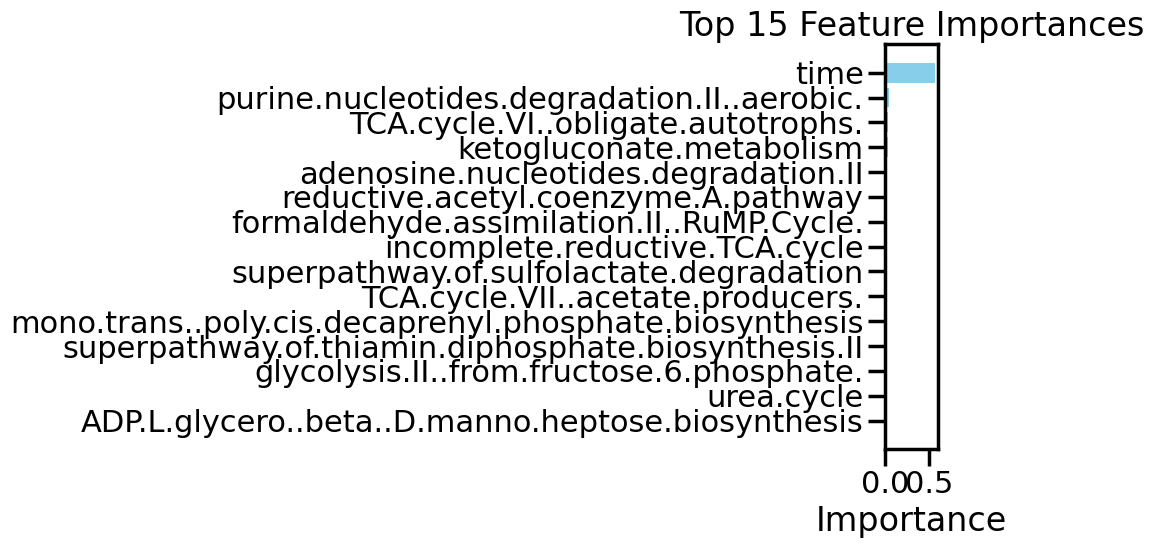

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:811: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 147.03605942232193 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv

---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 155.24594577059736 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 151.407677862677 at iteration 5.
INFO     [merf.py:307] Training GLL is 155.6961015792247 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

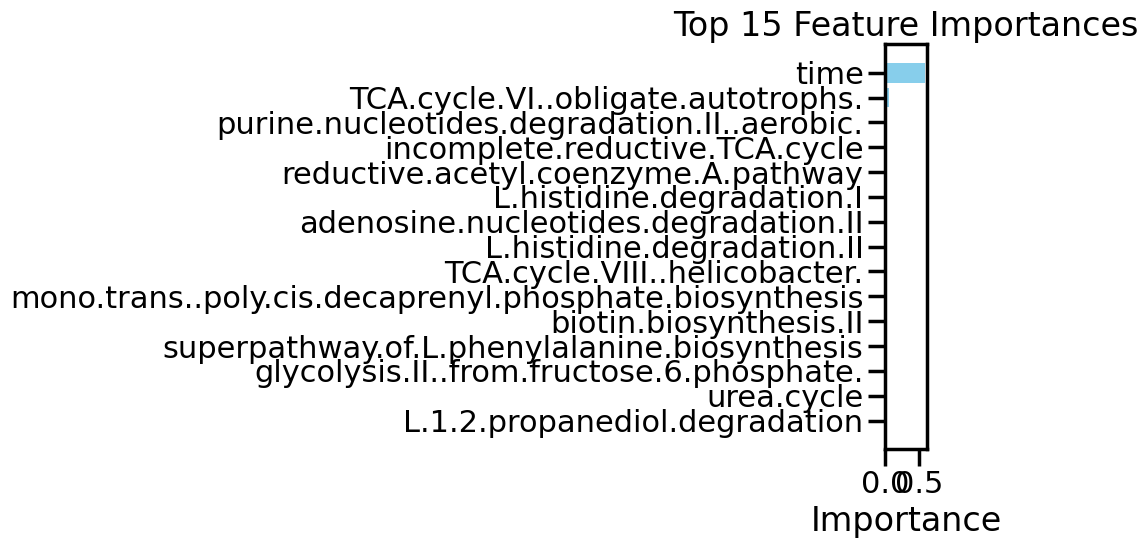

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 123.77821582092042 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 131.69756857398713 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 157.07224396003207 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 145.83816727243365 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

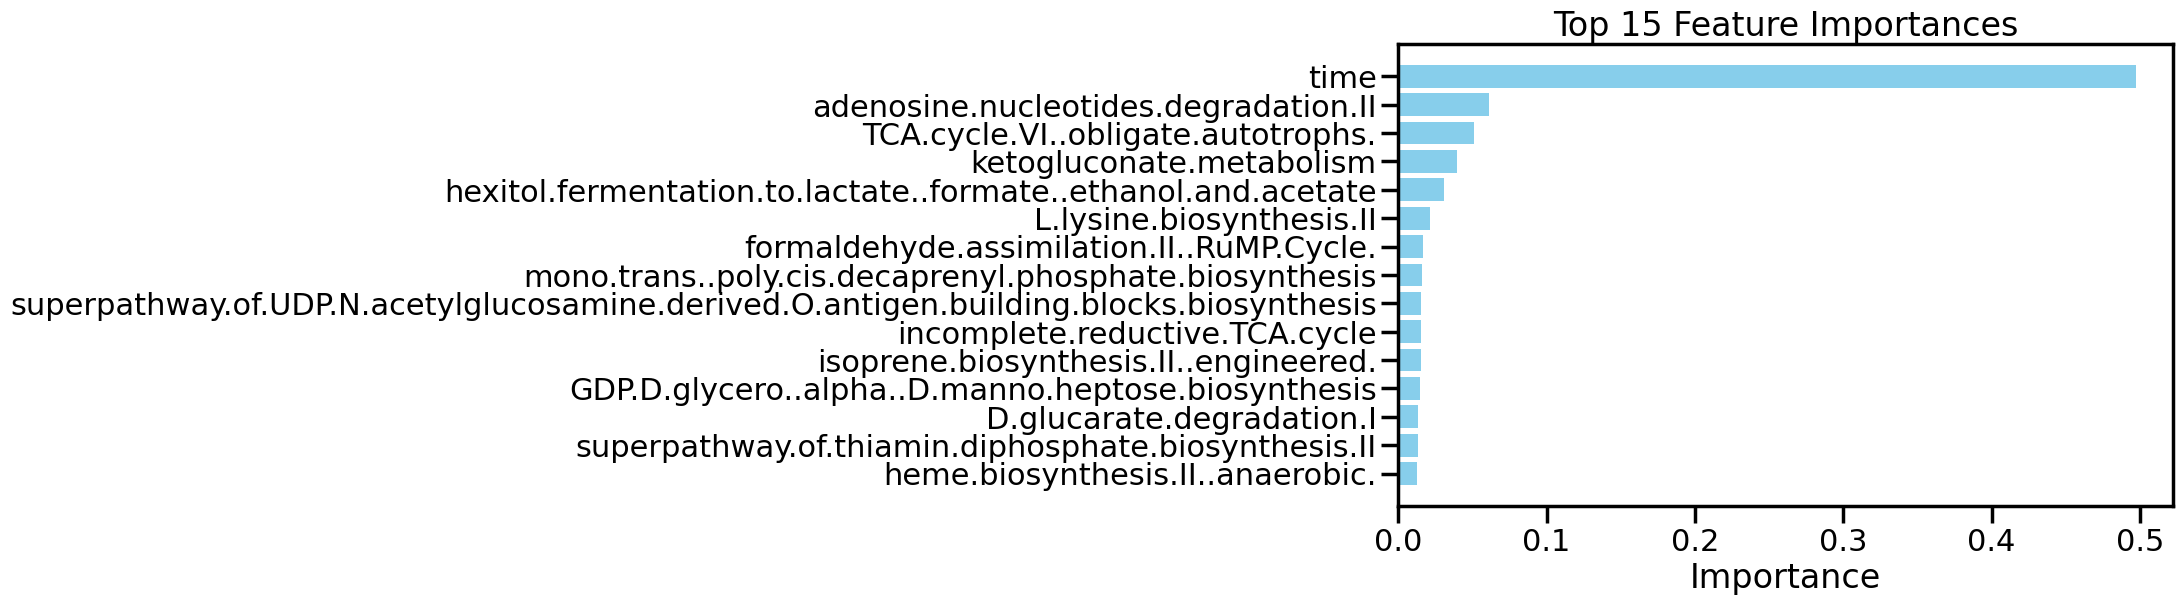

---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 88.80694027244121 at iteration 1.
INFO     [merf.py:307] Training GLL is 112.65657055008481 at iteration 2.
INFO     [merf.py:307] Training GLL is 112.82649038061324 at iteration 3.
INFO     [merf.py:307] Training GLL is 113.91295374250548 at iteration 4.
INFO     [merf.py:307] Training GLL is 113.68699995966288 at iteration 5.
INFO     [merf.py:307] Training GLL is 108.14955291784857 at iteration 6.
INFO     [merf.py:307] Training GLL is 113.49672402995078 at iteration 7.
INFO     [merf.py:307] Training GLL is 113.46709498532337 at iteration 8.
INFO     [merf.py:307] Training GLL is 106.6506071058398 at iteration 9.
INFO     [merf.py:307] Training GLL is 105.29039795763289 at iteration 10.


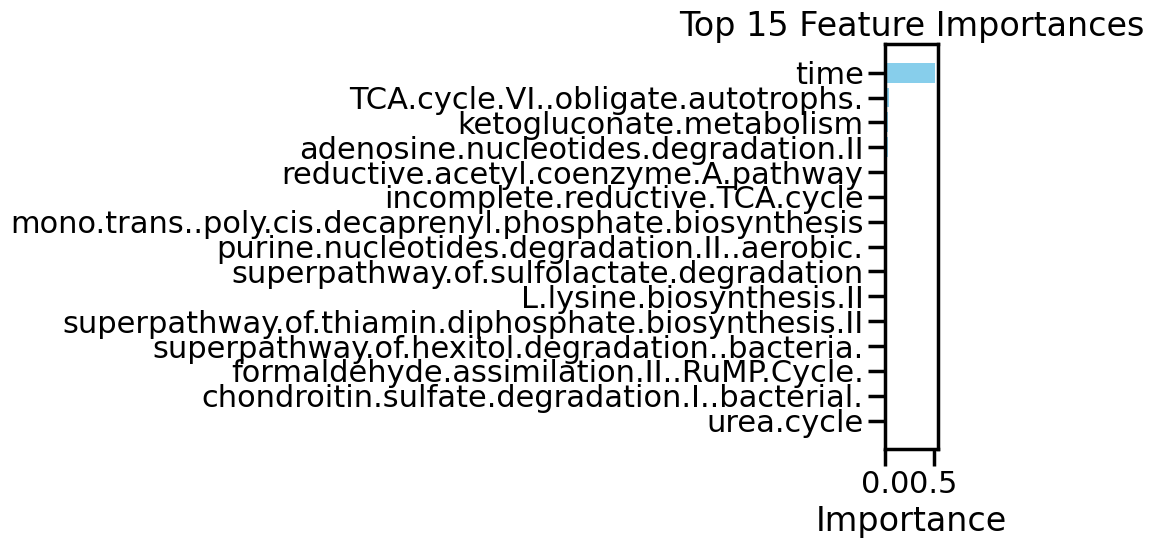

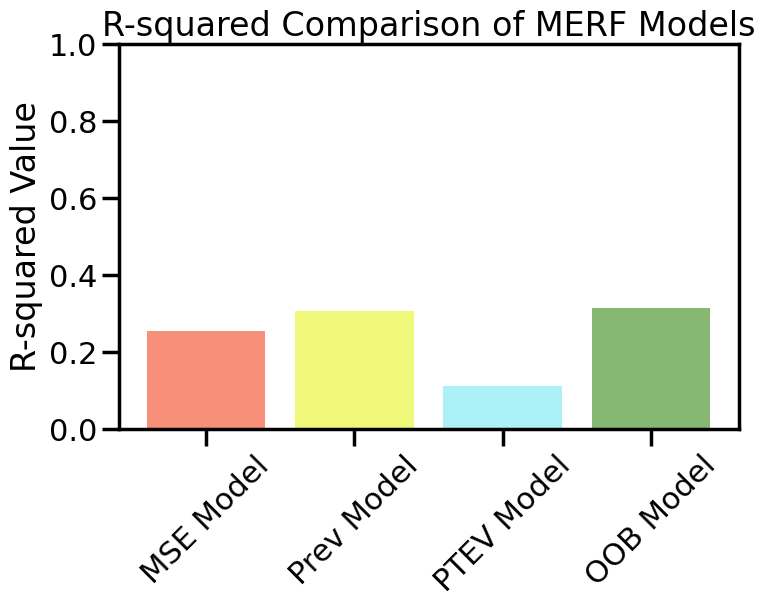

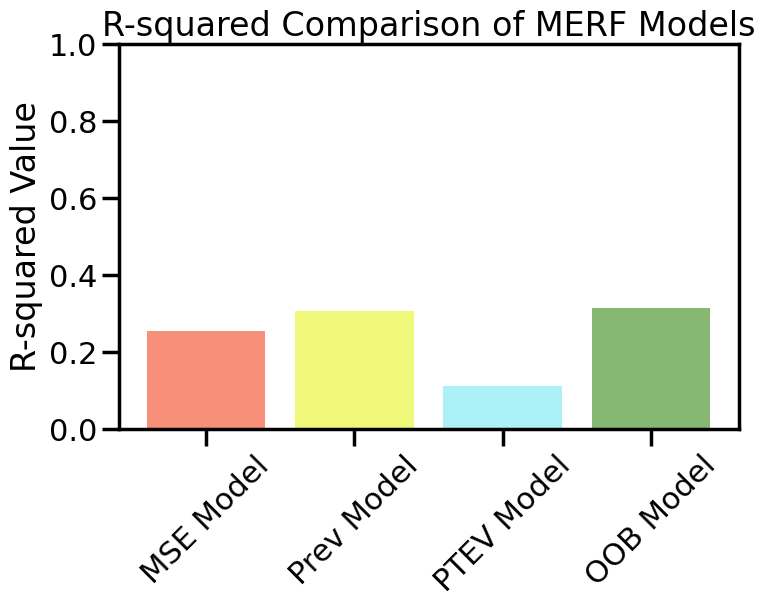

Best model: OOB Model with R-squared: 0.3134


ValueError: too many values to unpack (expected 2)

In [33]:
column_sets = {
    #"basic": basic,
    #"meta_keep": meta_keep,
    #"only_grs": only_grs, 
    #"only_taxa": only_taxa,
    #"only_micom": only_micom,
    "only_pathway": only_pathway
}
# Loop through each column set and create DATA
for key, columns in column_sets.items():
    DATA = delta[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    OUT = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/finetuning_csvs/{key}_delta.csv"
    output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/final_merf_plots/"
    r2_out =  f"{key}_delta_r2.pdf"
    r2_adj_out = f"{key}_delta_r2_adj.pdf"
    feature_imp_out = f"{key}_delta_ft_imp.pdf"
    results_filename = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/final_merf_dfs/{key}_delta.csv"

# Create train and test sets for the current subset
train_set = DATA[DATA[ID_VAR].isin(train_names)]  # Select rows where ID_VAR is in train_names
test_set = DATA[DATA[ID_VAR].isin(test_names)]    # Select rows where ID_VAR is in test_names

# Ensure clusters_train and clusters_test are pandas Series
clusters_train = pd.Series(train_set[ID_VAR])  # Convert to pandas Series
clusters_test = pd.Series(test_set[ID_VAR])    # Convert to pandas Series

# Proceed with MERF analysis for the current subset
print("---------- Select predictors for training set ----------")
X = train_set.drop([BMI_VAR, ID_VAR], axis=1)
Y = train_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
Z = np.ones((train_set.shape[0], 1))  # Create random effects matrix with ones

# Check lengths before fitting
print(f"Length of X: {len(X)}, Length of clusters_train: {len(clusters_train)}, Length of Y: {len(Y)}")
assert len(X) == len(clusters_train), "Length of X does not match length of clusters_train"
assert len(X) == len(Y), "Length of X does not match length of Y"
print("Final columns after drop:", X.columns.to_list())
print("X train values:", train_set[BMI_VAR])

print("---------- Select predictors for test set ----------")
X_new = test_set.drop([BMI_VAR, ID_VAR], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match
Y_new = test_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set[ID_VAR])  # Convert to pandas Series
Z_new = np.ones((len(X_new), 1))  # Create random effects matrix with ones
time_new = test_set[TIME_VAR].astype(float).to_numpy()  # Convert time values to numeric arrayo numeric array

# Hyperparameters to tune
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None],
    'min_samples_split': [0.05, 0.1, 0.15],
    'max_iter': [2, 10],
    'n_splits': [3, 5, 10] #cross-validation
}
# Create training features
# X = train_set.drop(columns=columns_to_drop, errors='ignore')
y = train_set[[BMI_VAR]]
y = y[BMI_VAR].to_numpy() # Convert Y to numeric array
clusters = train_set[ID_VAR].to_numpy() # Get ID variables
z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

best_score = float('inf')
best_params = {}
results = []  # Initialize a list to store the results of each iteration

# Loop through all possible combinations of parameters
total_combinations = len(list(itertools.product(*param_grid.values())))  # Calculate total combinations
for idx, params in enumerate(itertools.product(*param_grid.values())):
    n_estimators, max_depth, min_samples_split, max_iter, n_splits = params
    
    # Print progress
    progress_percentage = (idx + 1) / total_combinations * 100
    print(f"Combination: {params}\n")
    print(f"Progress: {progress_percentage:.2f}% completed\n")
    scores, prev, ptev, oob_scores = [], [], [], []  # Initialize lists for scores

    # K-fold cross-validation with variable n_splits
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(X):
        #print("Train indices:", train_index)
        #print("Test indices:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Use .iloc for row selection
        y_train, y_test = y[train_index], y[test_index]
        clusters_train, clusters_test = clusters[train_index], pd.Series(clusters[test_index])
        z_train, z_test = z[train_index], z[test_index]

        print("Length of clusters_train:", len(clusters_train))
        print("Length of clusters_test:", len(clusters_test))
        #print("Train indices:", train_index)
        #print("Test indices:", test_index)

        model = MERF(
                # Specify the fixed effects model as a Random Forest Regressor
            fixed_effects_model=RandomForestRegressor(
                n_estimators=n_estimators,  # Number of trees in the forest
                max_depth=max_depth,  # Maximum depth of each tree
                min_samples_split=min_samples_split,  # Minimum samples required to split an internal node
                n_jobs=1,  # Number of jobs to run in parallel
                oob_score=True  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
                ),
                # Generalized Linear Model (GLM) early stopping threshold
            gll_early_stop_threshold=None,  # No early stopping threshold set
                # Maximum number of iterations for the MERF algorithm
            max_iterations=max_iter  # Maximum number of iterations to run the MERF algorithm
            )
        model.fit(X_train.select_dtypes(include=[np.number]), z_train, pd.Series(clusters_train), y_train)
        y_pred = model.predict(X_test, z_test, clusters_test)
        scores.append(np.mean((y_pred - y_test) ** 2)) # MSE
        
        # Calculate ptev and prev
        total_variance = np.var(y_test)
        random_effect_variance = np.var(y_test - y_pred)
        fixed_effect_variance = total_variance - random_effect_variance

        ptev.append(np.mean(fixed_effect_variance / total_variance if total_variance > 0 else 0))
        prev.append(np.mean(random_effect_variance / total_variance if total_variance > 0 else 0))

        # Calculate OOB score
        forest = model.trained_fe_model
        oob_score = round(forest.oob_score_ * 100, 1)  # percent variation
        oob_scores.append(oob_score)

        # Print ptev, prev, and OOB score for the current iteration
        print(f"Combination, ptev: {np.mean(ptev):.4f}, prev: {np.mean(prev):.4f}, OOB Score: {oob_score:.4f}")

    # Calculate the mean of the scores for the current combination of parameters
    mean_score = np.mean(scores)
    if mean_score < best_score:
        best_score = mean_score
        best_params = params

    # Append the results of the current iteration to the results list
    result_dict = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'max_iter': max_iter,
        'n_splits': n_splits,
        'mean_mse_score': mean_score,
        'mean_prev': np.mean(prev),
        'mean_ptev': np.mean(ptev),
        'oob_score': np.mean(oob_scores)
    }
    results.append(result_dict)

print("Best parameters:", best_params)
print("Best score:", best_score)

# Convert the results list to a DataFrame and save it to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(OUT, index=False)

print("---------- Run MERF models ----------")
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters,
    X_new, Y_new, Z_new, clusters_new,
    results_df,
    output_dir, r2_out, r2_adj_out, 
    feature_imp_out, results_filename, time_new)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)
print("---------- Done saving Merf output ----------")